In [1]:
"""
SHAP analysis was conducted after identifying the most important variables for each indicator.
XGBoost models were run using different combinations of variables.
Only model combinations achieving a Kling–Gupta Efficiency (KGE) ≥ 0.60 were retained.
This threshold ensured that only models with meaningful predictive performance were considered.
The selected variables from these well-performing models were then analysed using SHAP to evaluate their contribution to predictability.
"""

In [ ]:
import numpy as np
import os
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm

In [2]:
font_path = fm.findfont("Times New Roman")
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16
plt.rcParams["text.color"] = "black"
plt.rcParams["axes.labelcolor"] = "black"
plt.rcParams["xtick.color"] = "black"
plt.rcParams["ytick.color"] = "black"


In [3]:
def calculate_KGE(predictions, observations):
    mean_pred = np.mean(predictions)
    mean_obs = np.mean(observations)

    std_pred = np.std(predictions)
    std_obs = np.std(observations)

    r = np.corrcoef(predictions, observations)[0, 1]

    alpha = std_pred / std_obs
    beta = mean_pred / mean_obs

    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge

In [4]:
#Daily Streamflow

In [5]:
Hydro_data = pd.read_csv("ShellCreek_Hydro_Data.csv")
Hydro_data['Date'] = pd.to_datetime(Hydro_data['Date'])
Hydro_data = Hydro_data[(Hydro_data['Date'] >= '1991-01-01') & (Hydro_data['Date'] <= '2021-12-31')]
Hydro_data.set_index('Date', inplace=True)
Hydro_data['Streamflow - Daily'] = Hydro_data['Streamflow - Daily'].interpolate(method='time')
Hydro_data.reset_index('Date', inplace=True)
Hydro_data = Hydro_data.groupby(pd.Grouper(key='Date', freq='YE')).mean()
Hydro_data.reset_index(drop=True, inplace=True)

Hydro_data = Hydro_data.drop(columns=['Minimum Temperature'])
Hydro_data = Hydro_data.drop(columns=['Mean Temperature'])
Hydro_data = Hydro_data.drop(columns=['Maximum Temperature'])
Hydro_data = Hydro_data.drop(columns=['Precipitation'])
Hydro_data = Hydro_data.drop(columns=['Dew Point Temperature'])
Hydro_data = Hydro_data.drop(columns=['Maximum Vapor Pressure Deficit'])

In [6]:
Hydro_data = pd.read_csv("ShellCreek_Hydro_Data.csv")
Hydro_data['Date'] = pd.to_datetime(Hydro_data['Date'])
Hydro_data = Hydro_data[ (Hydro_data['Date'] >= '1991-01-01') &  (Hydro_data['Date'] <= '2021-12-31')]
Hydro_data.set_index('Date', inplace=True)
Hydro_data['Streamflow - Daily'] = Hydro_data['Streamflow - Daily'].interpolate(method='time')
Hydro_data = Hydro_data.resample('YE').mean()
Hydro_data = Hydro_data.drop(columns=['Minimum Temperature', 'Mean Temperature','Maximum Temperature', 'Precipitation',  'Dew Point Temperature', 'Maximum Vapor Pressure Deficit'])
Hydro_data.reset_index(drop=True, inplace=True)

In [7]:
Crop_Coverage = pd.read_excel("Shell Creek_Cover Crop Extent_1990-2021.xlsx")
Crop_Health = pd.read_excel("Shell Creek_Crop Persistence_1990-2021.xlsx")
Summer_Crop = pd.read_excel("Shell Creek_Summer Crop_1990-2021.xlsx")
CP_Data = pd.concat([Crop_Coverage, Crop_Health, Summer_Crop], axis = 1)
CP_Data = CP_Data.loc[:,~CP_Data.columns.duplicated()]
CP_Data = CP_Data[CP_Data['Year'] >= 1991]
columns_to_retain = ['Cover Crops Extent', 'Winter Commodity Crops Extent', 'Vegetation Health']  
CP_Data = CP_Data[columns_to_retain]
CP_Data.reset_index(drop=True, inplace=True)

In [8]:
All_Parameters = pd.concat([CP_Data, Hydro_data], axis = 1)
num_columns = All_Parameters.shape[1]
print("Number of columns:", num_columns)

Number of columns: 6


In [9]:
All_Parameters

,Cover Crops Extent,Winter Commodity Crops Extent,Vegetation Health,Minimum Vapor Pressure Deficit,Snow Depth,Streamflow - Daily
0,294.672712,2.446340,32.914386,1.203644,16.131507,28.195288
1,235.738170,0.000000,0.000000,0.997186,2.177778,29.616667
2,5156.438877,0.000000,6.227046,1.021123,25.235616,137.994521
3,7220.037442,0.000000,334.703723,1.422849,11.250689,64.884932
4,780.604695,0.000000,2.668734,1.050219,6.429752,62.216438
5,4859.542220,0.000000,33.803964,0.974426,5.022039,62.136612
6,586.231902,11.786909,0.000000,0.935863,2.803324,44.861096
7,816.632604,0.000000,93.850479,0.773151,5.626374,68.430137
8,18383.129370,0.000000,8339.126567,0.876767,8.884932,90.484932
9,554.429489,1.111973,59.601726,0.825219,10.336066,39.341530


In [10]:
X = All_Parameters.drop('Streamflow - Daily', axis=1)
y = All_Parameters['Streamflow - Daily']

In [11]:
features = X.columns
features

Index(['Cover Crops Extent', 'Winter Commodity Crops Extent',
       'Vegetation Health', 'Minimum Vapor Pressure Deficit', 'Snow Depth'],
      dtype='object')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
y_pred = xgb.predict(X_test)
y_test = y_test.to_numpy().flatten()
KGE = calculate_KGE(y_pred, y_test)
print(f'KGE = {np.round(KGE, 2)}')
shap_explainer = shap.Explainer(xgb)
shap_values = shap_explainer(X)
print(f'The shape of shap_values is {np.shape(shap_values.values)}')

KGE = 0.73
The shape of shap_values is (31, 5)


<Figure size 640x480 with 0 Axes>

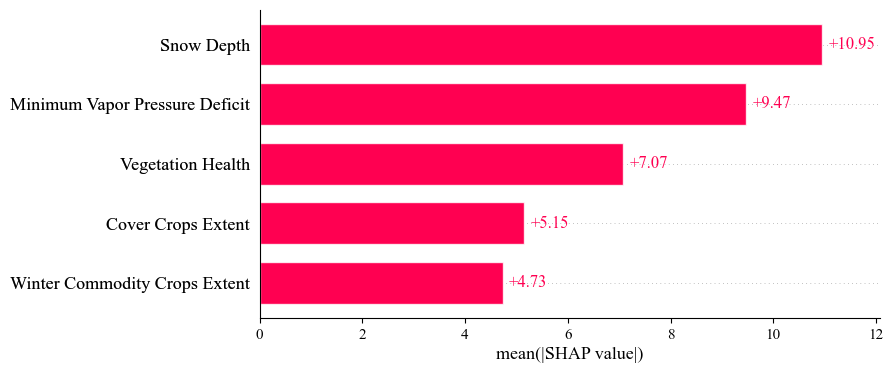

In [14]:
# Create stacked force plot for the first 10 observations
plt.figure()
fp = shap.force_plot(shap_values[0:10])
shap.save_html('force_plot.html', fp)
# Create bar plot for all observations
plt.figure()
shap.plots.bar(shap_values)

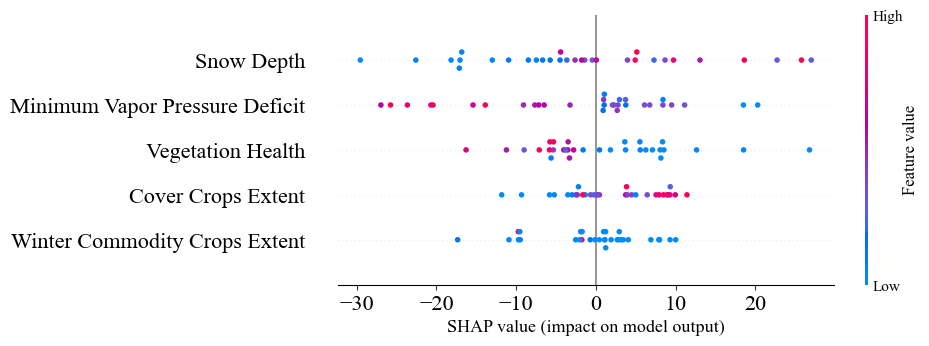

In [15]:
font_prop = fm.FontProperties(family="Times New Roman", size=16)
shap.plots.beeswarm(shap_values, show=False)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_prop)
    label.set_color("black")
ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.set_title(ax.get_title(), fontproperties=font_prop, color="black")
plt.show()

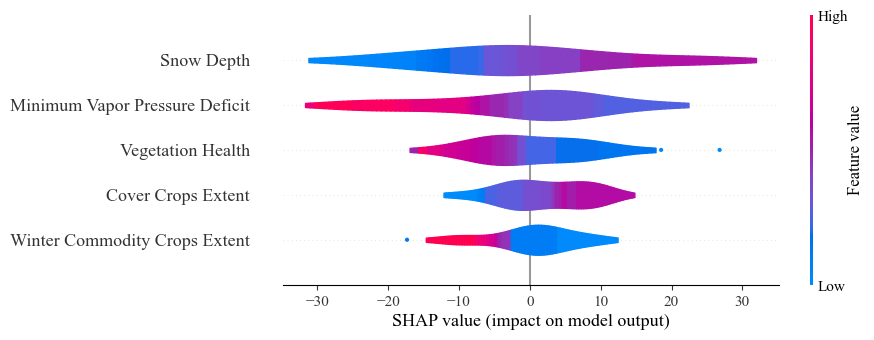

In [16]:
# Create violin plot for all observations
plt.figure()
shap.plots.violin(shap_values)

In [17]:
#Peakstreamflow

In [18]:
Hydro_data = pd.read_csv("ShellCreek_Hydro_Data.csv")
Hydro_data['Date'] = pd.to_datetime(Hydro_data['Date'])
Hydro_data = Hydro_data[(Hydro_data['Date'] >= '1991-01-01') & (Hydro_data['Date'] <= '2021-12-31')]
Hydro_data.set_index('Date', inplace=True)
Hydro_data['Streamflow - Daily'] = Hydro_data['Streamflow - Daily'].interpolate(method='time')
Hydro_data.reset_index('Date', inplace=True)
Hydro_data = Hydro_data.groupby(pd.Grouper(key='Date', freq='YE')).mean()
Hydro_data.reset_index(drop=True, inplace=True)
Hydro_data = Hydro_data.drop(columns=['Minimum Temperature', 'Maximum Temperature'])

In [19]:
Peak_annual_streamflow = pd.read_excel("Shell Creek Peakflow.xlsx")
Peak_annual_streamflow = Peak_annual_streamflow[Peak_annual_streamflow['Year'].between(1991, 2021)]
Peak_annual_streamflow = Peak_annual_streamflow.drop(columns=['Year'])
Peak_annual_streamflow.reset_index(drop=True, inplace=True)

In [20]:
Crop_Coverage = pd.read_excel("Shell Creek_Cover Crop Extent_1990-2021.xlsx")
Crop_Health = pd.read_excel("Shell Creek_Crop Persistence_1990-2021.xlsx")
Summer_Crop = pd.read_excel("Shell Creek_Summer Crop_1990-2021.xlsx")
CP_Data = pd.concat([Crop_Coverage, Crop_Health, Summer_Crop], axis = 1)
CP_Data = CP_Data.loc[:,~CP_Data.columns.duplicated()]
CP_Data = CP_Data[CP_Data['Year'] >= 1991]
CP_Data.reset_index(drop=True, inplace=True)
columns_to_retain = ['Cover Crops Extent', 'Winter Commodity Crops Extent', 'Vegetation Health','Summer Cropping Extent']
CP_Data = CP_Data[columns_to_retain]

In [21]:
All_Parameters = pd.concat([CP_Data, Hydro_data, Peak_annual_streamflow], axis = 1)
num_columns = All_Parameters.shape[1]
print("Number of columns:", num_columns)

Number of columns: 12


In [22]:
All_Parameters

,Cover Crops Extent,Winter Commodity Crops Extent,Vegetation Health,Summer Cropping Extent,Precipitation,Dew Point Temperature,Mean Temperature,Minimum Vapor Pressure Deficit,Maximum Vapor Pressure Deficit,Snow Depth,Streamflow - Daily,Peak Streamflow (cfs)
0,294.672712,2.446340,32.914386,257786.583125,1.714411,4.003288,10.176986,1.203644,14.069726,16.131507,28.195288,1480.0
1,235.738170,0.000000,0.000000,83247.376423,2.345082,3.886066,9.511749,0.997186,11.074836,2.177778,29.616667,645.0
2,5156.438877,0.000000,6.227046,224943.140970,2.726329,3.141918,7.927123,1.021123,9.380082,25.235616,137.994521,3600.0
3,7220.037442,0.000000,334.703723,302973.809607,1.865178,3.112329,9.384110,1.422849,12.681123,11.250689,64.884932,1790.0
4,780.604695,0.000000,2.668734,301177.974020,1.775863,3.761096,9.246301,1.050219,12.116986,6.429752,62.216438,2380.0
5,4859.542220,0.000000,33.803964,264614.983853,2.333388,2.365574,7.912022,0.974426,10.523743,5.022039,62.136612,2320.0
6,586.231902,11.786909,0.000000,305648.325864,1.742575,3.502740,9.063836,0.935863,11.813863,2.803324,44.861096,1300.0
7,816.632604,0.000000,93.850479,215226.280476,2.119342,5.632877,10.464658,0.773151,11.777370,5.626374,68.430137,1570.0
8,18383.129370,0.000000,8339.126567,309496.862687,1.960027,4.179726,10.102466,0.876767,12.325068,8.884932,90.484932,5230.0
9,554.429489,1.111973,59.601726,187143.192594,1.438142,3.549727,9.462022,0.825219,12.911721,10.336066,39.341530,1630.0


In [23]:
X = All_Parameters.drop('Peak Streamflow (cfs)', axis=1)
y = All_Parameters['Peak Streamflow (cfs)']

In [24]:
features = X.columns
features

Index(['Cover Crops Extent', 'Winter Commodity Crops Extent',
       'Vegetation Health', 'Summer Cropping Extent', 'Precipitation',
       'Dew Point Temperature', 'Mean Temperature',
       'Minimum Vapor Pressure Deficit', 'Maximum Vapor Pressure Deficit',
       'Snow Depth', 'Streamflow - Daily'],
      dtype='object')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
# Predict using trained model 
y_pred = xgb.predict(X_test)
# Convert to numpy array
y_test = y_test.to_numpy().flatten()
KGE = calculate_KGE(y_pred, y_test)
print(f'KGE = {np.round(KGE, 2)}')
# Calculate SHAP values
shap_explainer = shap.Explainer(xgb)
shap_values = shap_explainer(X)
print(f'The shape of shap_values is {np.shape(shap_values.values)}')

KGE = 0.61
The shape of shap_values is (31, 11)


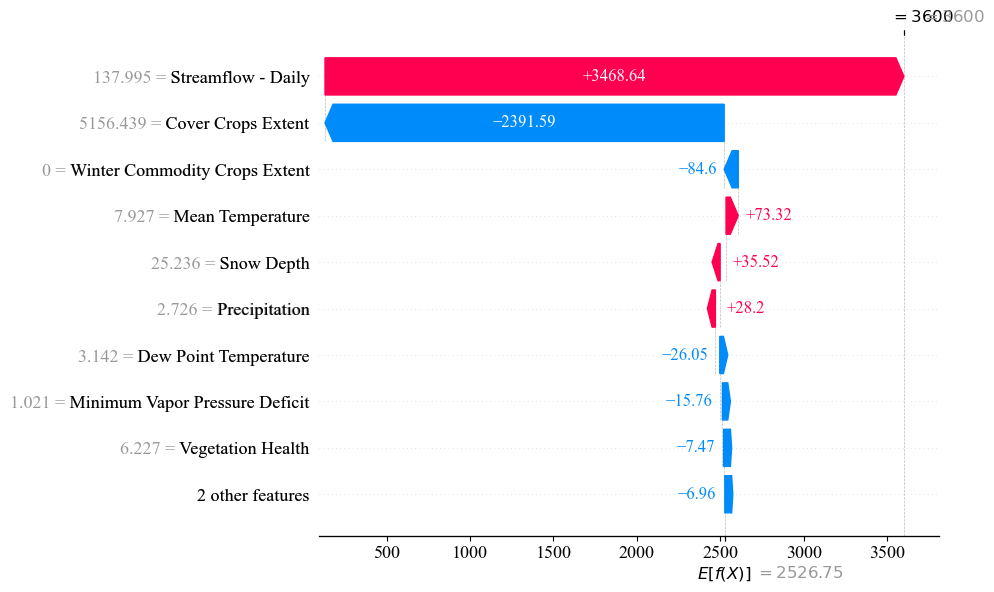

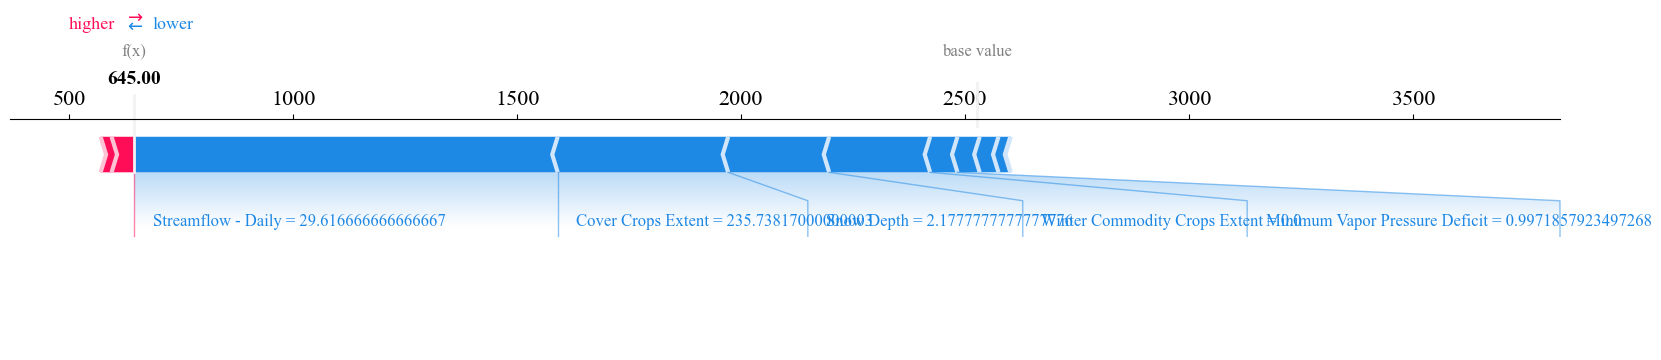

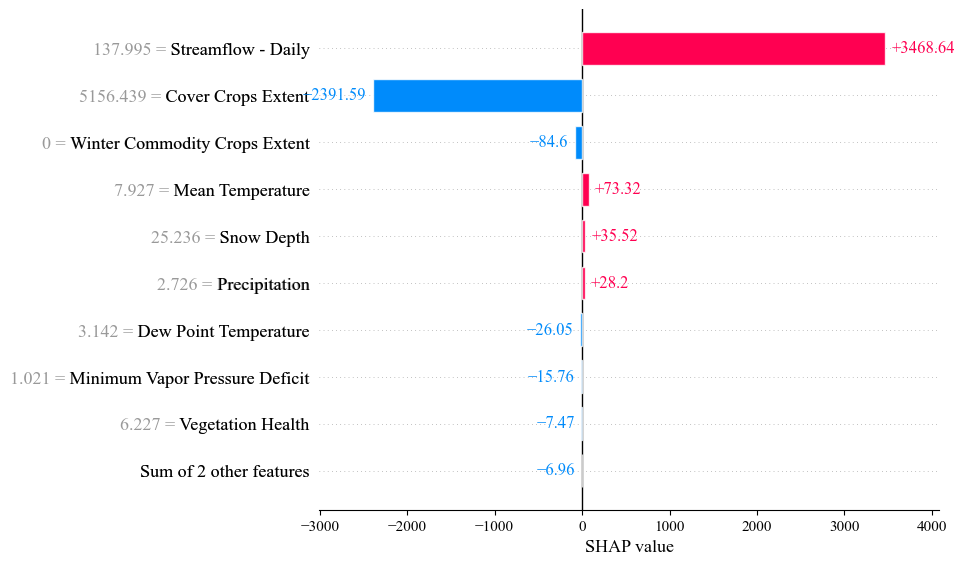

In [27]:
# Create waterfall plot for the third observation
plt.figure()
shap.plots.waterfall(shap_values[2])
# Create force plot for the third observation
shap.plots.force(shap_values[1], matplotlib=True)
# Create stacked force plot for the first 10 observations
plt.figure()
fp = shap.force_plot(shap_values[0:10])
shap.save_html('force_plot.html', fp)
# Create bar plot for the third observation
shap.plots.bar(shap_values[2])

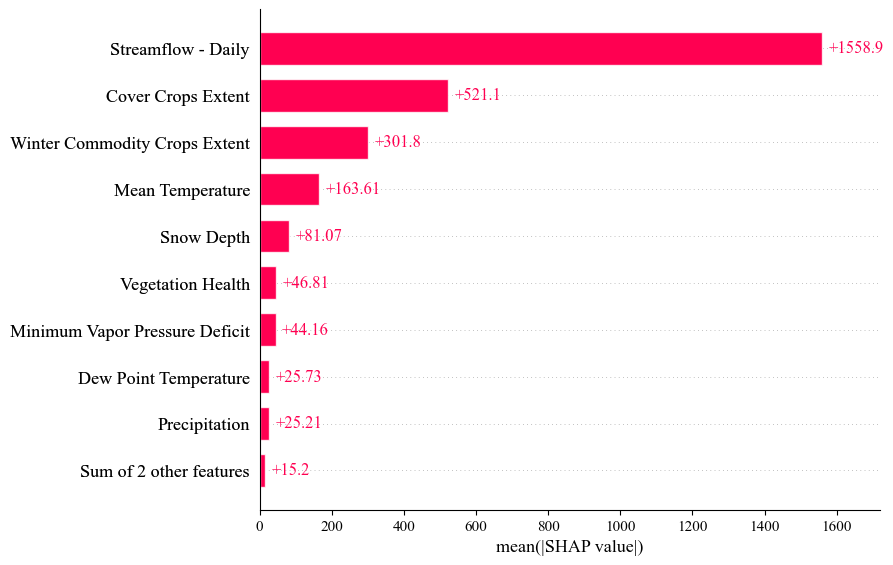

In [28]:
# Create bar plot for all observations
plt.figure()
shap.plots.bar(shap_values)

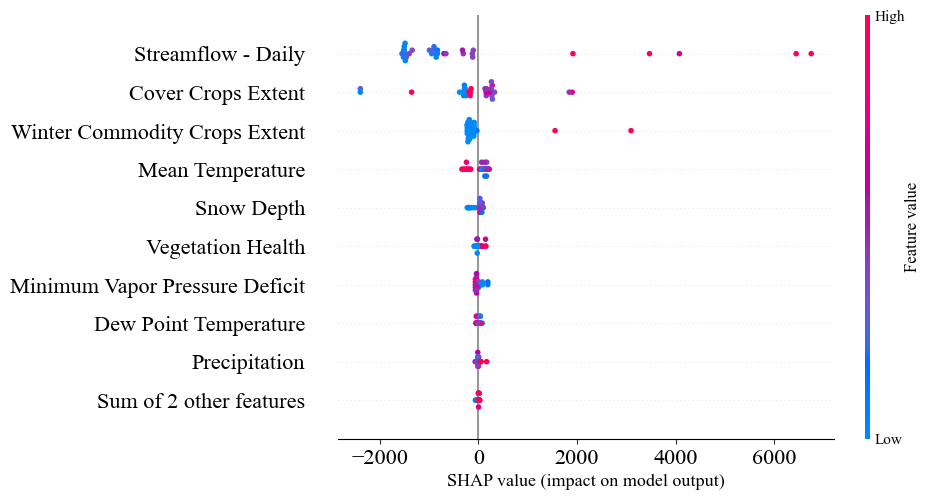

In [29]:
font_prop = fm.FontProperties(family="Times New Roman", size=16)
# Plot beeswarm
shap.plots.beeswarm(shap_values, show=False)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_prop)
    label.set_color("black")

ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.set_title(ax.get_title(), fontproperties=font_prop, color="black")
plt.show()

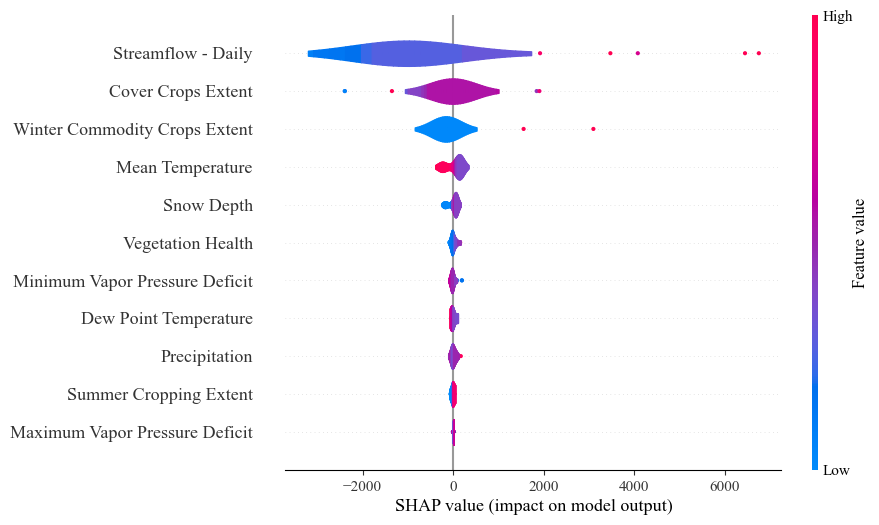

In [30]:
# Create violin plot for all observations
plt.figure()
shap.plots.violin(shap_values)

In [31]:
#Dissolved Oxygen

In [32]:
#For Growing Season Analysis - May to September

Inorganic_Nitrate_data_G = pd.read_excel("NDEE Nitrate_Filtered.xlsx")
Inorganic_Nitrate_data_G['Date'] = pd.to_datetime(Inorganic_Nitrate_data_G['Date'])
Inorganic_Nitrate_data_filtered_G = Inorganic_Nitrate_data_G[Inorganic_Nitrate_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Inorganic_Nitrate_data_filtered_G['Year'] = Inorganic_Nitrate_data_filtered_G['Date'].dt.year
Inorganic_Nitrate_data_yearly_avg_G = Inorganic_Nitrate_data_filtered_G.groupby('Year')['Inorganic Nitrogen Concentration'].mean()

Total_Phosphorus_data_G = pd.read_excel("NDEE Total Phosphorus_Filtered.xlsx")
Total_Phosphorus_data_G['Date'] = pd.to_datetime(Total_Phosphorus_data_G['Date'])
Total_Phosphorus_data_filtered_G = Total_Phosphorus_data_G[Total_Phosphorus_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Phosphorus_data_filtered_G['Year'] = Total_Phosphorus_data_filtered_G['Date'].dt.year
Total_Phosphorus_data_yearly_avg_G = Total_Phosphorus_data_filtered_G.groupby('Year')['Total Phosphorus Concentration'].mean()

Turbidity_data_G = pd.read_excel("NDEE_Turbidity_Filtered.xlsx")
Turbidity_data_G['Date'] = pd.to_datetime(Turbidity_data_G['Date'])
Turbidity_data_filtered_G = Turbidity_data_G[Turbidity_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Turbidity_data_filtered_G['Year'] = Turbidity_data_filtered_G['Date'].dt.year
Turbidity_data_yearly_avg_G = Turbidity_data_filtered_G.groupby('Year')['Turbidity'].mean()

Total_Suspended_Solids_data_G = pd.read_excel("NDEE Total Suspended Solids_Filtered.xlsx")
Total_Suspended_Solids_data_G['Date'] = pd.to_datetime(Total_Suspended_Solids_data_G['Date'])
Total_Suspended_Solids_data_filtered_G = Total_Suspended_Solids_data_G[Total_Suspended_Solids_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Suspended_Solids_data_filtered_G['Year'] = Total_Suspended_Solids_data_filtered_G['Date'].dt.year
Total_Suspended_Solids_data_yearly_avg_G = Total_Suspended_Solids_data_filtered_G.groupby('Year')['Total Suspended Solids'].mean()

Stream_Temperature_data_G = pd.read_excel("NDEE Stream Temperature_Filtered.xlsx")
Stream_Temperature_data_G['Date'] = pd.to_datetime(Stream_Temperature_data_G['Date'])
Stream_Temperature_data_filtered_G = Stream_Temperature_data_G[Stream_Temperature_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Stream_Temperature_data_filtered_G['Year'] = Stream_Temperature_data_filtered_G['Date'].dt.year
Stream_Temperature_data_yearly_avg_G = Stream_Temperature_data_filtered_G.groupby('Year')['Stream Temperature'].mean()

Specific_Conductance_data_G = pd.read_excel("NDEE Specific Conductance_Filtered.xlsx")
Specific_Conductance_data_G['Date'] = pd.to_datetime(Specific_Conductance_data_G['Date'])
Specific_Conductance_data_filtered_G = Specific_Conductance_data_G[Specific_Conductance_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Specific_Conductance_data_filtered_G['Year'] = Specific_Conductance_data_filtered_G['Date'].dt.year
Specific_Conductance_data_yearly_avg_G = Specific_Conductance_data_filtered_G.groupby('Year')['Specific Conductance'].mean()

Dissolved_Oxygen_data_G = pd.read_excel("NDEE Dissolved Oxygen_Filtered.xlsx")
Dissolved_Oxygen_data_G['Date'] = pd.to_datetime(Dissolved_Oxygen_data_G['Date'])
Dissolved_Oxygen_data_filtered_G = Dissolved_Oxygen_data_G[Dissolved_Oxygen_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Dissolved_Oxygen_data_filtered_G['Year'] = Dissolved_Oxygen_data_filtered_G['Date'].dt.year
Dissolved_Oxygen_data_yearly_avg_G = Dissolved_Oxygen_data_filtered_G.groupby('Year')['Dissolved oxygen'].mean()

Atrazine_data_G = pd.read_excel("NDEE Atrazine_Filtered.xlsx")
Atrazine_data_G['Date'] = pd.to_datetime(Atrazine_data_G['Date'])
Atrazine_data_filtered_G = Atrazine_data_G[Atrazine_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Atrazine_data_filtered_G['Year'] = Atrazine_data_filtered_G['Date'].dt.year
Atrazine_data_yearly_avg_G = Atrazine_data_filtered_G.groupby('Year')['Atrazine'].mean()

EColi_data_G = pd.read_excel("NDEE E Coli_Filtered.xlsx")
EColi_data_G['Date'] = pd.to_datetime(EColi_data_G['Date'])
EColi_data_filtered_G = EColi_data_G[EColi_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
EColi_data_filtered_G['Year'] = EColi_data_filtered_G['Date'].dt.year
EColi_data_yearly_avg_G = EColi_data_filtered_G.groupby('Year')['E. Coli'].mean()


WQ_Data_GrowingS = pd.concat([Inorganic_Nitrate_data_yearly_avg_G, Total_Phosphorus_data_yearly_avg_G, Turbidity_data_yearly_avg_G, 
                              Total_Suspended_Solids_data_yearly_avg_G,
                            Stream_Temperature_data_yearly_avg_G, Specific_Conductance_data_yearly_avg_G, Dissolved_Oxygen_data_yearly_avg_G,
                            Atrazine_data_yearly_avg_G, EColi_data_yearly_avg_G], axis = 1)

WQ_Data_GrowingS.reset_index(drop=True, inplace=True)
WQ_Data_GrowingS = WQ_Data_GrowingS.drop(columns=['E. Coli'])
WQ_Data_GrowingS


,Inorganic Nitrogen Concentration,Total Phosphorus Concentration,Turbidity,Total Suspended Solids,Stream Temperature,Specific Conductance,Dissolved oxygen,Atrazine
0,0.838673,0.323026,11.500000,14.000000,24.730000,581.000000,9.253333,0.966667
1,2.341049,3.530759,104.033333,2887.800000,20.092000,558.600000,6.760000,22.674000
2,2.217458,3.224359,1003.730000,1757.350000,21.430000,516.300000,9.954000,2.950000
3,2.011984,1.257671,44.796000,895.900000,21.987000,520.300000,9.240000,6.005556
4,1.914100,1.001750,108.883333,328.000000,21.440000,528.222222,8.521250,6.385000
5,5.153934,1.383316,362.566667,572.300000,22.655556,648.777778,6.754444,2.218889
6,3.610000,1.142500,516.720000,691.375000,20.952000,597.800000,8.100000,1.662000
7,3.570382,0.726215,285.872727,259.477273,19.712273,637.954545,8.769091,2.640909
8,3.622000,2.986800,1888.000000,2377.200000,21.094000,527.600000,6.334000,2.342000
9,3.910000,0.634600,165.360000,237.400000,20.992000,709.080000,8.724000,0.648000


In [33]:
Hydro_data = pd.read_csv("ShellCreek_Hydro_Data.csv")
Hydro_data['Date'] = pd.to_datetime(Hydro_data['Date'])
Hydro_data = Hydro_data[(Hydro_data['Date'] >= '2002-01-01') & (Hydro_data['Date'] <= '2021-12-31')]
Hydro_data.set_index('Date', inplace=True)
Hydro_data['Month'] = Hydro_data.index.month
Hydro_data_filtered = Hydro_data[(Hydro_data['Month'] >= 5) & (Hydro_data['Month'] <= 9)]
Hydro_data_grouped = Hydro_data_filtered.groupby(Hydro_data_filtered.index.year).mean()
Hydro_data_grouped.reset_index(inplace=True)
Hydro_data_grouped.rename(columns={'index': 'Year'}, inplace=True)
Hydro_data_grouped.drop(columns=['Date','Month','Snow Depth','Minimum Temperature','Maximum Temperature',
    'Dew Point Temperature','Maximum Vapor Pressure Deficit','Minimum Vapor Pressure Deficit','Precipitation'], inplace=True)
print(Hydro_data_grouped)

    Mean Temperature  Streamflow - Daily
0          20.645098           30.467320
1          19.593464           53.424837
2          19.549020          117.195425
3          21.241830           35.903007
4          20.656863           20.842092
5          21.313072           92.911765
6          19.696078          214.258170
7          19.000654           39.341830
8          20.688235          185.623529
9          20.198039           80.209804
10         21.821569           31.388039
11         20.621569           32.356863
12         19.664706           48.076797
13         20.355556           34.636601
14         20.828758           88.869935
15         20.381699           45.093922
16         21.577124          104.845752
17         20.639216           83.147712
18         20.688889           43.253856
19         21.326797           37.751895


In [34]:
Crop_Coverage = pd.read_excel("Shell Creek_Cover Crop Extent_1990-2021.xlsx")
Crop_Health = pd.read_excel("Shell Creek_Crop Persistence_1990-2021.xlsx")
Summer_Crop = pd.read_excel("Shell Creek_Summer Crop_1990-2021.xlsx")
CP_Data = pd.concat([Crop_Coverage, Crop_Health, Summer_Crop], axis = 1)
CP_Data = CP_Data.loc[:,~CP_Data.columns.duplicated()]
CP_Data = CP_Data[CP_Data['Year'] >= 2002]
CP_Data.reset_index(drop=True, inplace=True)
columns_to_retain = ['Vegetation Health', 'Cover Crops Extent', 'Winter Commodity Crops Extent','Summer Cropping Extent']
CP_Data = CP_Data[columns_to_retain]

In [35]:
All_Parameters = pd.concat([CP_Data, Hydro_data_grouped,  WQ_Data_GrowingS], axis = 1)
All_Parameters = All_Parameters.drop(columns=['Cover Crops Extent'])
num_columns = All_Parameters.shape[1]
print("Number of columns:", num_columns)

Number of columns: 13


In [36]:
X = All_Parameters.drop('Dissolved oxygen', axis=1)
y = All_Parameters['Dissolved oxygen']

In [37]:
features = X.columns
features

Index(['Vegetation Health', 'Winter Commodity Crops Extent',
       'Summer Cropping Extent', 'Mean Temperature', 'Streamflow - Daily',
       'Inorganic Nitrogen Concentration', 'Total Phosphorus Concentration',
       'Turbidity', 'Total Suspended Solids', 'Stream Temperature',
       'Specific Conductance', 'Atrazine'],
      dtype='object')

In [38]:
# Carry out train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# Configure and fit XGBoost
xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [39]:
# Predict using trained model 
y_pred = xgb.predict(X_test)
# Convert to numpy array
y_test = y_test.to_numpy().flatten()
KGE = calculate_KGE(y_pred, y_test)
print(f'KGE = {np.round(KGE, 2)}')
# Calculate SHAP values
shap_explainer = shap.Explainer(xgb)
shap_values = shap_explainer(X)
print(f'The shape of shap_values is {np.shape(shap_values.values)}')

KGE = 0.85
The shape of shap_values is (20, 12)


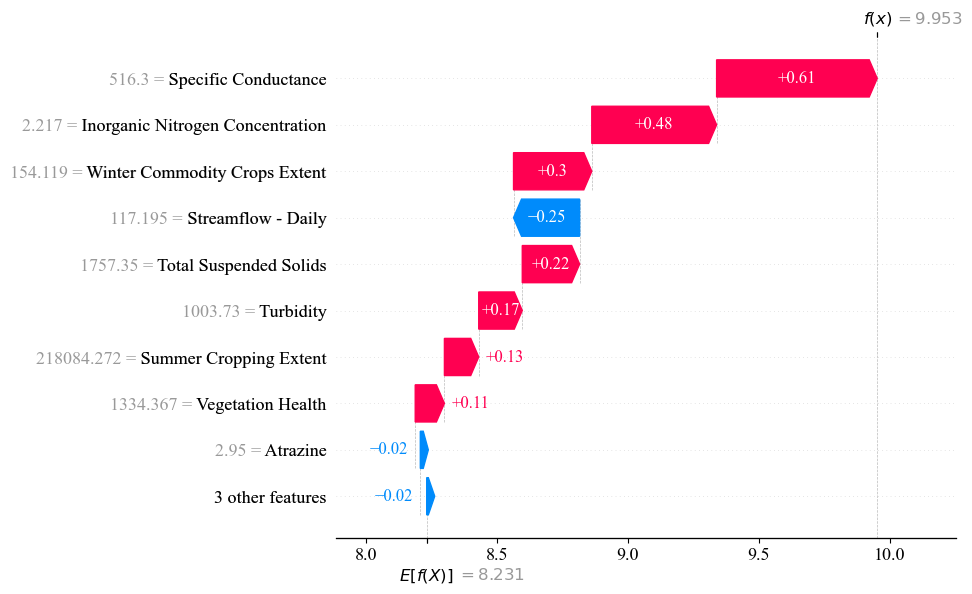

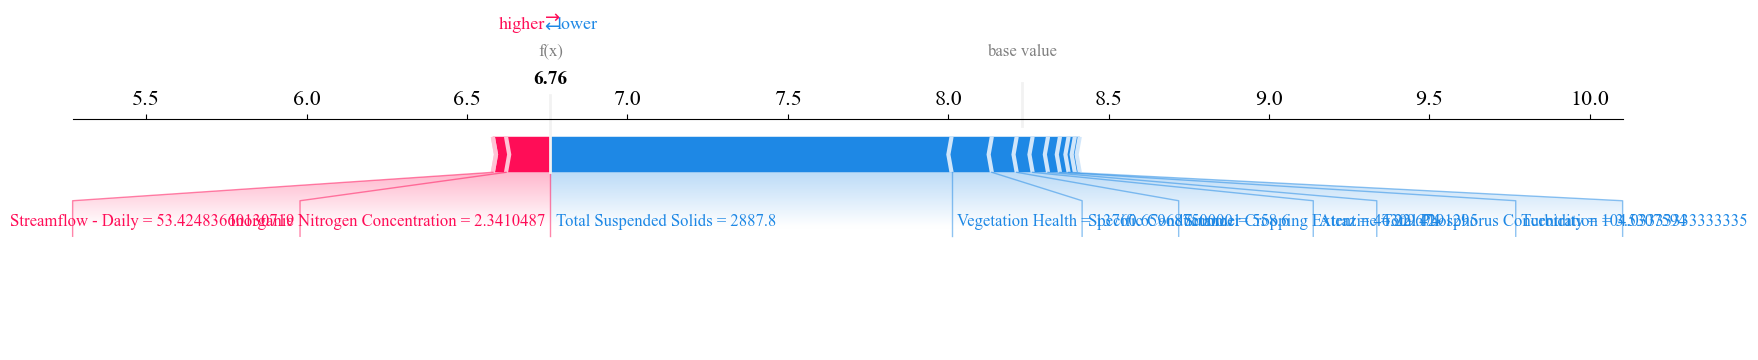

<Figure size 640x480 with 0 Axes>

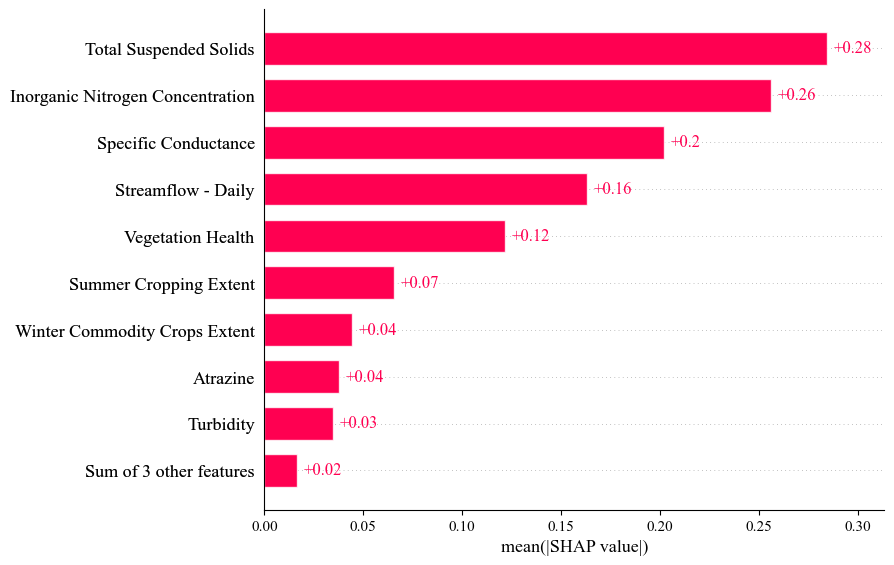

In [40]:
# Create waterfall plot for the third observation
plt.figure()
shap.plots.waterfall(shap_values[2])
# Create force plot for the third observation
shap.plots.force(shap_values[1], matplotlib=True)
# Create stacked force plot for the first 10 observations
plt.figure()
fp = shap.force_plot(shap_values[0:10])
shap.save_html('force_plot.html', fp)
# Create bar plot for all observations
plt.figure()
shap.plots.bar(shap_values)

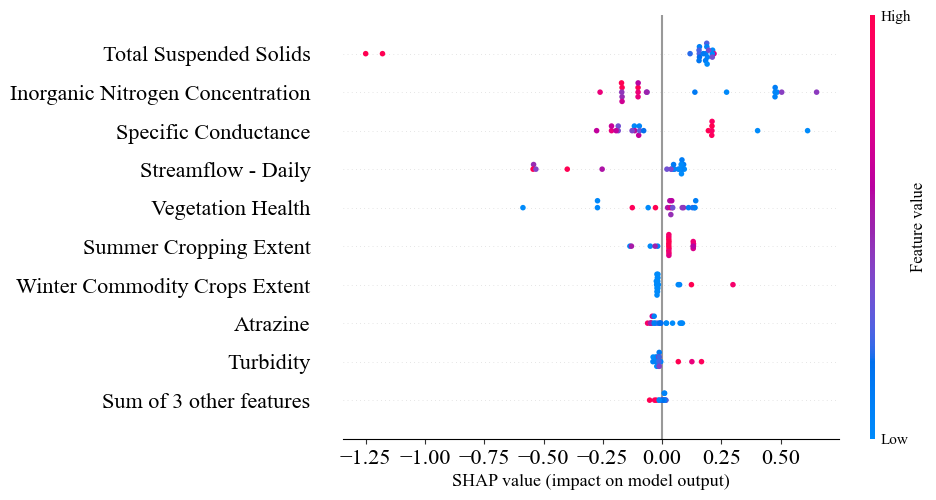

In [41]:
font_prop = fm.FontProperties(family="Times New Roman", size=16)
# Plot beeswarm
shap.plots.beeswarm(shap_values, show=False)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_prop)
    label.set_color("black")
ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.set_title(ax.get_title(), fontproperties=font_prop, color="black")
plt.show()

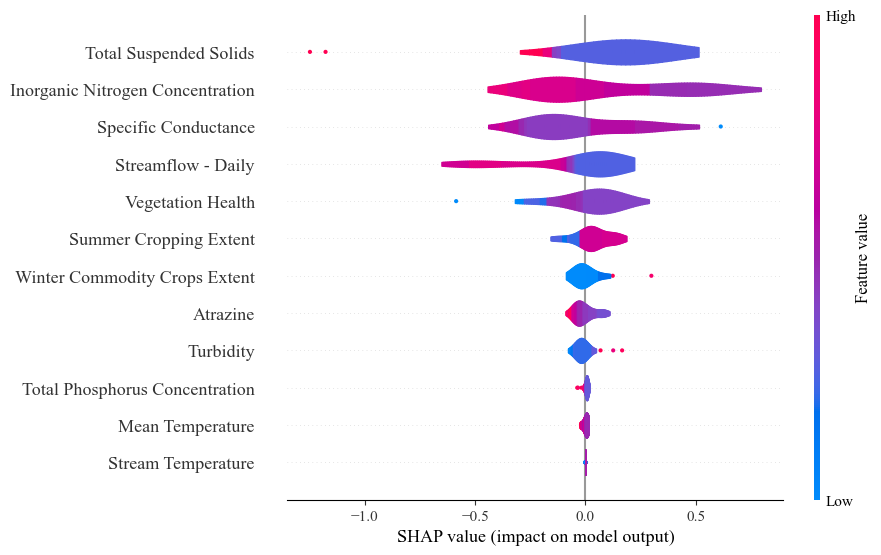

In [42]:
# Create violin plot for all observations
plt.figure()
shap.plots.violin(shap_values)

In [43]:
#Turbidity

In [44]:
#For Growing Season Analysis - May to September

Inorganic_Nitrate_data_G = pd.read_excel("NDEE Nitrate_Filtered.xlsx")
Inorganic_Nitrate_data_G['Date'] = pd.to_datetime(Inorganic_Nitrate_data_G['Date'])
Inorganic_Nitrate_data_filtered_G = Inorganic_Nitrate_data_G[Inorganic_Nitrate_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Inorganic_Nitrate_data_filtered_G['Year'] = Inorganic_Nitrate_data_filtered_G['Date'].dt.year
Inorganic_Nitrate_data_yearly_avg_G = Inorganic_Nitrate_data_filtered_G.groupby('Year')['Inorganic Nitrogen Concentration'].mean()

Total_Phosphorus_data_G = pd.read_excel("NDEE Total Phosphorus_Filtered.xlsx")
Total_Phosphorus_data_G['Date'] = pd.to_datetime(Total_Phosphorus_data_G['Date'])
Total_Phosphorus_data_filtered_G = Total_Phosphorus_data_G[Total_Phosphorus_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Phosphorus_data_filtered_G['Year'] = Total_Phosphorus_data_filtered_G['Date'].dt.year
Total_Phosphorus_data_yearly_avg_G = Total_Phosphorus_data_filtered_G.groupby('Year')['Total Phosphorus Concentration'].mean()

Turbidity_data_G = pd.read_excel("NDEE_Turbidity_Filtered.xlsx")
Turbidity_data_G['Date'] = pd.to_datetime(Turbidity_data_G['Date'])
Turbidity_data_filtered_G = Turbidity_data_G[Turbidity_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Turbidity_data_filtered_G['Year'] = Turbidity_data_filtered_G['Date'].dt.year
Turbidity_data_yearly_avg_G = Turbidity_data_filtered_G.groupby('Year')['Turbidity'].mean()

Total_Suspended_Solids_data_G = pd.read_excel("NDEE Total Suspended Solids_Filtered.xlsx")
Total_Suspended_Solids_data_G['Date'] = pd.to_datetime(Total_Suspended_Solids_data_G['Date'])
Total_Suspended_Solids_data_filtered_G = Total_Suspended_Solids_data_G[Total_Suspended_Solids_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Suspended_Solids_data_filtered_G['Year'] = Total_Suspended_Solids_data_filtered_G['Date'].dt.year
Total_Suspended_Solids_data_yearly_avg_G = Total_Suspended_Solids_data_filtered_G.groupby('Year')['Total Suspended Solids'].mean()

Stream_Temperature_data_G = pd.read_excel("NDEE Stream Temperature_Filtered.xlsx")
Stream_Temperature_data_G['Date'] = pd.to_datetime(Stream_Temperature_data_G['Date'])
Stream_Temperature_data_filtered_G = Stream_Temperature_data_G[Stream_Temperature_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Stream_Temperature_data_filtered_G['Year'] = Stream_Temperature_data_filtered_G['Date'].dt.year
Stream_Temperature_data_yearly_avg_G = Stream_Temperature_data_filtered_G.groupby('Year')['Stream Temperature'].mean()

Specific_Conductance_data_G = pd.read_excel("NDEE Specific Conductance_Filtered.xlsx")
Specific_Conductance_data_G['Date'] = pd.to_datetime(Specific_Conductance_data_G['Date'])
Specific_Conductance_data_filtered_G = Specific_Conductance_data_G[Specific_Conductance_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Specific_Conductance_data_filtered_G['Year'] = Specific_Conductance_data_filtered_G['Date'].dt.year
Specific_Conductance_data_yearly_avg_G = Specific_Conductance_data_filtered_G.groupby('Year')['Specific Conductance'].mean()

Dissolved_Oxygen_data_G = pd.read_excel("NDEE Dissolved Oxygen_Filtered.xlsx")
Dissolved_Oxygen_data_G['Date'] = pd.to_datetime(Dissolved_Oxygen_data_G['Date'])
Dissolved_Oxygen_data_filtered_G = Dissolved_Oxygen_data_G[Dissolved_Oxygen_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Dissolved_Oxygen_data_filtered_G['Year'] = Dissolved_Oxygen_data_filtered_G['Date'].dt.year
Dissolved_Oxygen_data_yearly_avg_G = Dissolved_Oxygen_data_filtered_G.groupby('Year')['Dissolved oxygen'].mean()

Atrazine_data_G = pd.read_excel("NDEE Atrazine_Filtered.xlsx")
Atrazine_data_G['Date'] = pd.to_datetime(Atrazine_data_G['Date'])
Atrazine_data_filtered_G = Atrazine_data_G[Atrazine_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Atrazine_data_filtered_G['Year'] = Atrazine_data_filtered_G['Date'].dt.year
Atrazine_data_yearly_avg_G = Atrazine_data_filtered_G.groupby('Year')['Atrazine'].mean()

EColi_data_G = pd.read_excel("NDEE E Coli_Filtered.xlsx")
EColi_data_G['Date'] = pd.to_datetime(EColi_data_G['Date'])
EColi_data_filtered_G = EColi_data_G[EColi_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
EColi_data_filtered_G['Year'] = EColi_data_filtered_G['Date'].dt.year
EColi_data_yearly_avg_G = EColi_data_filtered_G.groupby('Year')['E. Coli'].mean()


WQ_Data_GrowingS = pd.concat([Inorganic_Nitrate_data_yearly_avg_G, Total_Phosphorus_data_yearly_avg_G, Turbidity_data_yearly_avg_G, 
                              Total_Suspended_Solids_data_yearly_avg_G,
                            Stream_Temperature_data_yearly_avg_G, Specific_Conductance_data_yearly_avg_G, Dissolved_Oxygen_data_yearly_avg_G,
                            Atrazine_data_yearly_avg_G, EColi_data_yearly_avg_G], axis = 1)

WQ_Data_GrowingS.reset_index(drop=True, inplace=True)
WQ_Data_GrowingS = WQ_Data_GrowingS.drop(columns=['E. Coli'])
WQ_Data_GrowingS

,Inorganic Nitrogen Concentration,Total Phosphorus Concentration,Turbidity,Total Suspended Solids,Stream Temperature,Specific Conductance,Dissolved oxygen,Atrazine
0,0.838673,0.323026,11.500000,14.000000,24.730000,581.000000,9.253333,0.966667
1,2.341049,3.530759,104.033333,2887.800000,20.092000,558.600000,6.760000,22.674000
2,2.217458,3.224359,1003.730000,1757.350000,21.430000,516.300000,9.954000,2.950000
3,2.011984,1.257671,44.796000,895.900000,21.987000,520.300000,9.240000,6.005556
4,1.914100,1.001750,108.883333,328.000000,21.440000,528.222222,8.521250,6.385000
5,5.153934,1.383316,362.566667,572.300000,22.655556,648.777778,6.754444,2.218889
6,3.610000,1.142500,516.720000,691.375000,20.952000,597.800000,8.100000,1.662000
7,3.570382,0.726215,285.872727,259.477273,19.712273,637.954545,8.769091,2.640909
8,3.622000,2.986800,1888.000000,2377.200000,21.094000,527.600000,6.334000,2.342000
9,3.910000,0.634600,165.360000,237.400000,20.992000,709.080000,8.724000,0.648000


In [45]:
Hydro_data = pd.read_csv("ShellCreek_Hydro_Data.csv")
Hydro_data['Date'] = pd.to_datetime(Hydro_data['Date'])
Hydro_data = Hydro_data[(Hydro_data['Date'] >= '2002-01-01') & (Hydro_data['Date'] <= '2021-12-31')]
Hydro_data.set_index('Date', inplace=True)
Hydro_data['Month'] = Hydro_data.index.month
Hydro_data_filtered = Hydro_data[(Hydro_data['Month'] >= 5) & (Hydro_data['Month'] <= 9)]
Hydro_data_grouped = Hydro_data_filtered.groupby(Hydro_data_filtered.index.year).mean()
Hydro_data_grouped.reset_index(inplace=True)
Hydro_data_grouped.drop(columns=['Date', 'Month', 'Snow Depth','Minimum Temperature', 'Maximum Temperature','Dew Point Temperature',
                                 'Maximum Vapor Pressure Deficit', 'Minimum Vapor Pressure Deficit','Precipitation'], inplace=True)
print(Hydro_data_grouped)

    Mean Temperature  Streamflow - Daily
0          20.645098           30.467320
1          19.593464           53.424837
2          19.549020          117.195425
3          21.241830           35.903007
4          20.656863           20.842092
5          21.313072           92.911765
6          19.696078          214.258170
7          19.000654           39.341830
8          20.688235          185.623529
9          20.198039           80.209804
10         21.821569           31.388039
11         20.621569           32.356863
12         19.664706           48.076797
13         20.355556           34.636601
14         20.828758           88.869935
15         20.381699           45.093922
16         21.577124          104.845752
17         20.639216           83.147712
18         20.688889           43.253856
19         21.326797           37.751895


In [46]:
Crop_Coverage = pd.read_excel("Shell Creek_Cover Crop Extent_1990-2021.xlsx")
Crop_Health = pd.read_excel("Shell Creek_Crop Persistence_1990-2021.xlsx")
Summer_Crop = pd.read_excel("Shell Creek_Summer Crop_1990-2021.xlsx")
CP_Data = pd.concat([Crop_Coverage, Crop_Health, Summer_Crop], axis = 1)
CP_Data = CP_Data.loc[:,~CP_Data.columns.duplicated()]
CP_Data = CP_Data[CP_Data['Year'] >= 2002]
CP_Data.reset_index(drop=True, inplace=True)
columns_to_retain = ['Vegetation Health', 'Cover Crops Extent', 'Winter Commodity Crops Extent','Summer Cropping Extent']
CP_Data = CP_Data[columns_to_retain]

In [47]:
All_Parameters = pd.concat([CP_Data, Hydro_data_grouped,  WQ_Data_GrowingS], axis = 1)
All_Parameters = All_Parameters.drop(columns=['Cover Crops Extent'])
All_Parameters = All_Parameters.drop(columns=['Total Phosphorus Concentration'])
All_Parameters = All_Parameters.drop(columns=['Total Suspended Solids'])
num_columns = All_Parameters.shape[1]
print("Number of columns:", num_columns)

Number of columns: 11


In [48]:
X = All_Parameters.drop('Turbidity', axis=1)
y = All_Parameters['Turbidity']

In [49]:
features = X.columns
features

Index(['Vegetation Health', 'Winter Commodity Crops Extent',
       'Summer Cropping Extent', 'Mean Temperature', 'Streamflow - Daily',
       'Inorganic Nitrogen Concentration', 'Stream Temperature',
       'Specific Conductance', 'Dissolved oxygen', 'Atrazine'],
      dtype='object')

In [50]:
# Carry out train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# Configure and fit XGBoost
xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
# Predict using trained model 
y_pred = xgb.predict(X_test)

# Convert to numpy array
y_test = y_test.to_numpy().flatten()

KGE = calculate_KGE(y_pred, y_test)
print(f'KGE = {np.round(KGE, 2)}')


KGE = 0.91


The shape of shap_values is (20, 10)


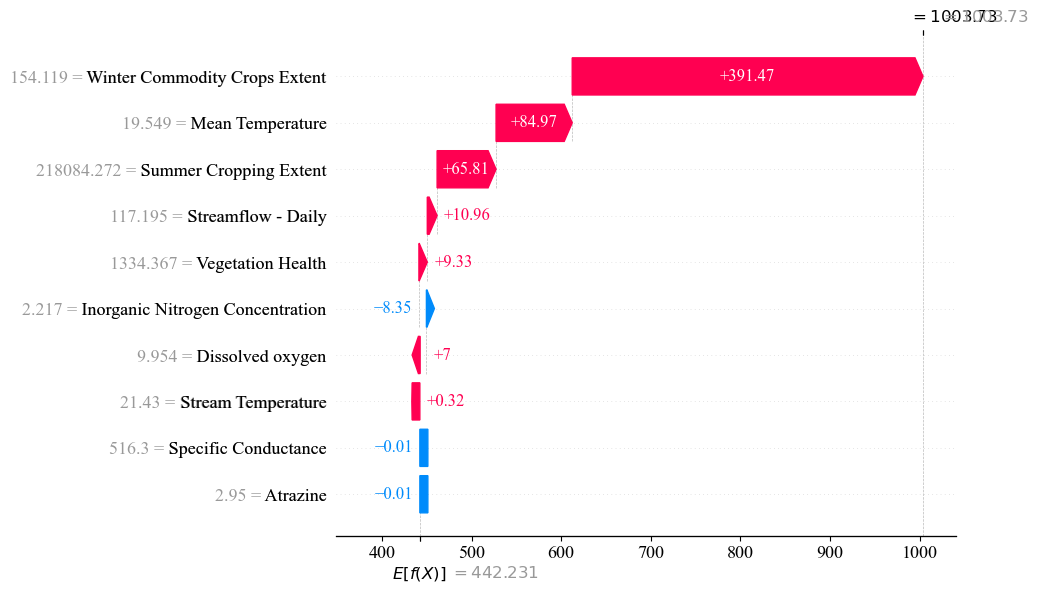

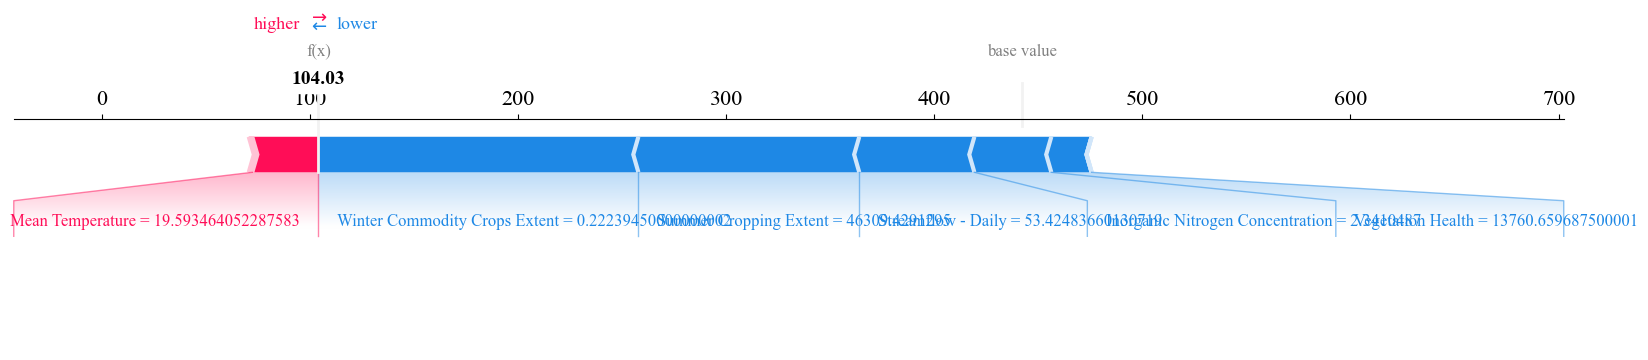

In [52]:
# Calculate SHAP values
shap_explainer = shap.Explainer(xgb)
shap_values = shap_explainer(X)
print(f'The shape of shap_values is {np.shape(shap_values.values)}')
# Create waterfall plot for the third observation
plt.figure()
shap.plots.waterfall(shap_values[2])
# Create force plot for the third observation
shap.plots.force(shap_values[1], matplotlib=True)

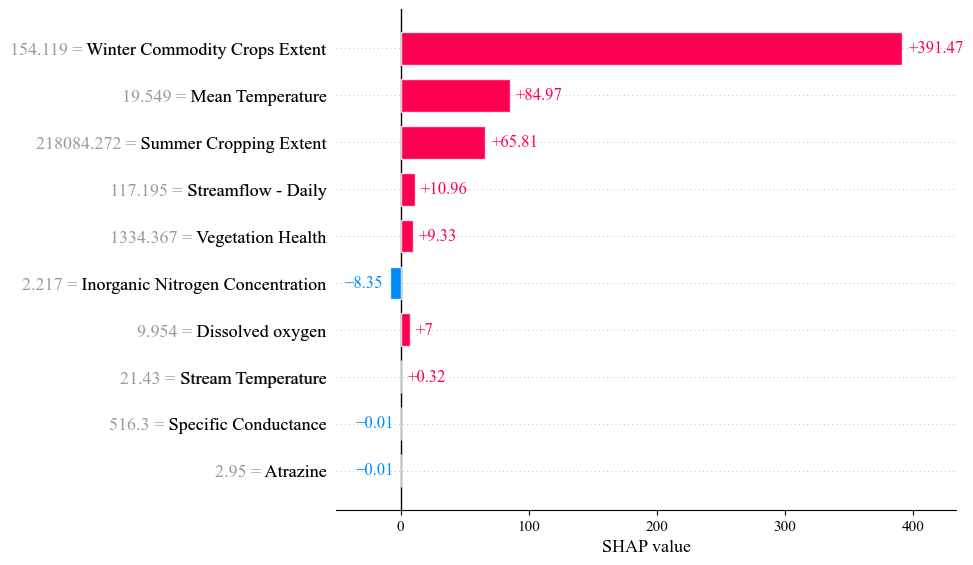

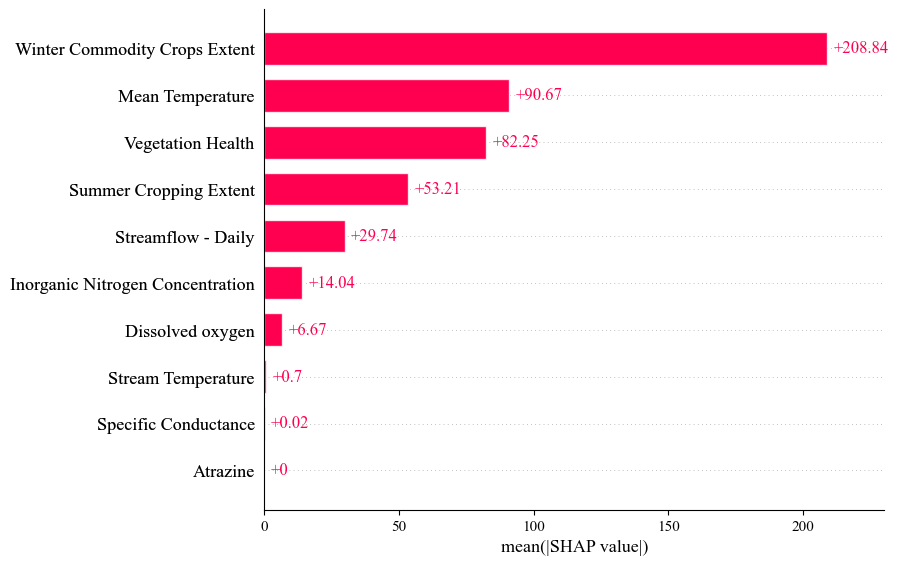

In [53]:
# Create stacked force plot for the first 10 observations
plt.figure()
fp = shap.force_plot(shap_values[0:10])
shap.save_html('force_plot.html', fp)
# Create bar plot for the third observation
shap.plots.bar(shap_values[2])
# Create bar plot for all observations
plt.figure()
shap.plots.bar(shap_values)

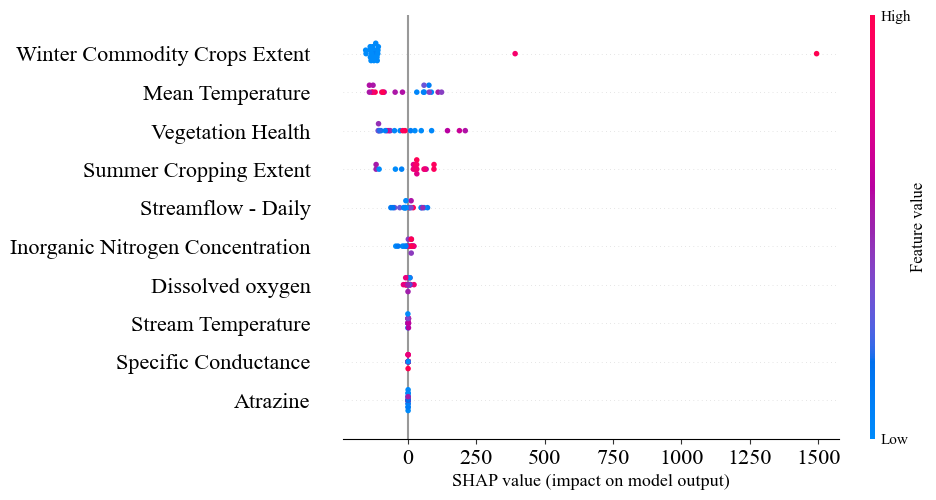

In [54]:
font_prop = fm.FontProperties(family="Times New Roman", size=16)
shap.plots.beeswarm(shap_values, show=False)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_prop)
    label.set_color("black")
ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.set_title(ax.get_title(), fontproperties=font_prop, color="black")
plt.show()

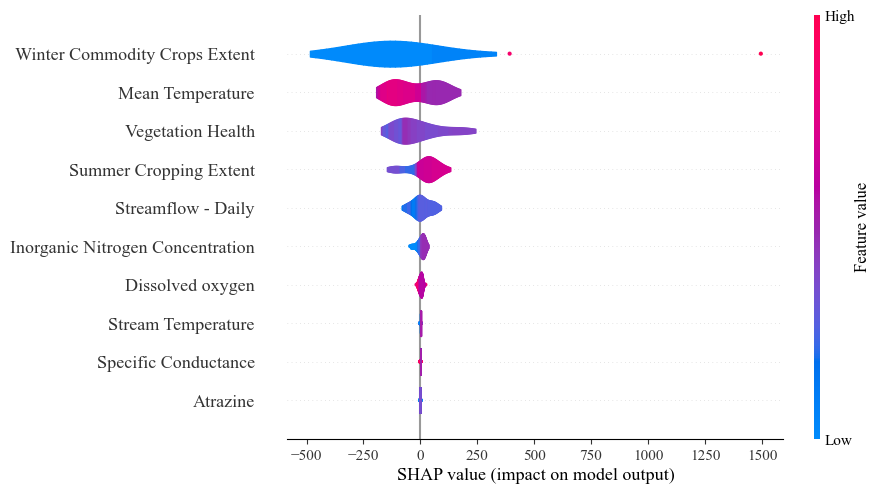

In [55]:
# Create violin plot for all observations
plt.figure()
shap.plots.violin(shap_values)

In [56]:
#Inorganic nitrogen

In [57]:
#For Growing Season Analysis - May to September
Inorganic_Nitrate_data_G = pd.read_excel("NDEE Nitrate_Filtered.xlsx")
Inorganic_Nitrate_data_G['Date'] = pd.to_datetime(Inorganic_Nitrate_data_G['Date'])
Inorganic_Nitrate_data_filtered_G = Inorganic_Nitrate_data_G[Inorganic_Nitrate_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Inorganic_Nitrate_data_filtered_G['Year'] = Inorganic_Nitrate_data_filtered_G['Date'].dt.year
Inorganic_Nitrate_data_yearly_avg_G = Inorganic_Nitrate_data_filtered_G.groupby('Year')['Inorganic Nitrogen Concentration'].mean()

Total_Phosphorus_data_G = pd.read_excel("NDEE Total Phosphorus_Filtered.xlsx")
Total_Phosphorus_data_G['Date'] = pd.to_datetime(Total_Phosphorus_data_G['Date'])
Total_Phosphorus_data_filtered_G = Total_Phosphorus_data_G[Total_Phosphorus_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Phosphorus_data_filtered_G['Year'] = Total_Phosphorus_data_filtered_G['Date'].dt.year
Total_Phosphorus_data_yearly_avg_G = Total_Phosphorus_data_filtered_G.groupby('Year')['Total Phosphorus Concentration'].mean()

Turbidity_data_G = pd.read_excel("NDEE_Turbidity_Filtered.xlsx")
Turbidity_data_G['Date'] = pd.to_datetime(Turbidity_data_G['Date'])
Turbidity_data_filtered_G = Turbidity_data_G[Turbidity_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Turbidity_data_filtered_G['Year'] = Turbidity_data_filtered_G['Date'].dt.year
Turbidity_data_yearly_avg_G = Turbidity_data_filtered_G.groupby('Year')['Turbidity'].mean()

Total_Suspended_Solids_data_G = pd.read_excel("NDEE Total Suspended Solids_Filtered.xlsx")
Total_Suspended_Solids_data_G['Date'] = pd.to_datetime(Total_Suspended_Solids_data_G['Date'])
Total_Suspended_Solids_data_filtered_G = Total_Suspended_Solids_data_G[Total_Suspended_Solids_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Suspended_Solids_data_filtered_G['Year'] = Total_Suspended_Solids_data_filtered_G['Date'].dt.year
Total_Suspended_Solids_data_yearly_avg_G = Total_Suspended_Solids_data_filtered_G.groupby('Year')['Total Suspended Solids'].mean()

Stream_Temperature_data_G = pd.read_excel("NDEE Stream Temperature_Filtered.xlsx")
Stream_Temperature_data_G['Date'] = pd.to_datetime(Stream_Temperature_data_G['Date'])
Stream_Temperature_data_filtered_G = Stream_Temperature_data_G[Stream_Temperature_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Stream_Temperature_data_filtered_G['Year'] = Stream_Temperature_data_filtered_G['Date'].dt.year
Stream_Temperature_data_yearly_avg_G = Stream_Temperature_data_filtered_G.groupby('Year')['Stream Temperature'].mean()

Specific_Conductance_data_G = pd.read_excel("NDEE Specific Conductance_Filtered.xlsx")
Specific_Conductance_data_G['Date'] = pd.to_datetime(Specific_Conductance_data_G['Date'])
Specific_Conductance_data_filtered_G = Specific_Conductance_data_G[Specific_Conductance_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Specific_Conductance_data_filtered_G['Year'] = Specific_Conductance_data_filtered_G['Date'].dt.year
Specific_Conductance_data_yearly_avg_G = Specific_Conductance_data_filtered_G.groupby('Year')['Specific Conductance'].mean()

Dissolved_Oxygen_data_G = pd.read_excel("NDEE Dissolved Oxygen_Filtered.xlsx")
Dissolved_Oxygen_data_G['Date'] = pd.to_datetime(Dissolved_Oxygen_data_G['Date'])
Dissolved_Oxygen_data_filtered_G = Dissolved_Oxygen_data_G[Dissolved_Oxygen_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Dissolved_Oxygen_data_filtered_G['Year'] = Dissolved_Oxygen_data_filtered_G['Date'].dt.year
Dissolved_Oxygen_data_yearly_avg_G = Dissolved_Oxygen_data_filtered_G.groupby('Year')['Dissolved oxygen'].mean()

Atrazine_data_G = pd.read_excel("NDEE Atrazine_Filtered.xlsx")
Atrazine_data_G['Date'] = pd.to_datetime(Atrazine_data_G['Date'])
Atrazine_data_filtered_G = Atrazine_data_G[Atrazine_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Atrazine_data_filtered_G['Year'] = Atrazine_data_filtered_G['Date'].dt.year
Atrazine_data_yearly_avg_G = Atrazine_data_filtered_G.groupby('Year')['Atrazine'].mean()

EColi_data_G = pd.read_excel("NDEE E Coli_Filtered.xlsx")
EColi_data_G['Date'] = pd.to_datetime(EColi_data_G['Date'])
EColi_data_filtered_G = EColi_data_G[EColi_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
EColi_data_filtered_G['Year'] = EColi_data_filtered_G['Date'].dt.year
EColi_data_yearly_avg_G = EColi_data_filtered_G.groupby('Year')['E. Coli'].mean()


WQ_Data_GrowingS = pd.concat([Inorganic_Nitrate_data_yearly_avg_G, Total_Phosphorus_data_yearly_avg_G, Turbidity_data_yearly_avg_G, 
                              Total_Suspended_Solids_data_yearly_avg_G,
                            Stream_Temperature_data_yearly_avg_G, Specific_Conductance_data_yearly_avg_G, Dissolved_Oxygen_data_yearly_avg_G,
                            Atrazine_data_yearly_avg_G, EColi_data_yearly_avg_G], axis = 1)

WQ_Data_GrowingS.reset_index(drop=True, inplace=True)
WQ_Data_GrowingS = WQ_Data_GrowingS.drop(columns=['E. Coli'])
WQ_Data_GrowingS

,Inorganic Nitrogen Concentration,Total Phosphorus Concentration,Turbidity,Total Suspended Solids,Stream Temperature,Specific Conductance,Dissolved oxygen,Atrazine
0,0.838673,0.323026,11.500000,14.000000,24.730000,581.000000,9.253333,0.966667
1,2.341049,3.530759,104.033333,2887.800000,20.092000,558.600000,6.760000,22.674000
2,2.217458,3.224359,1003.730000,1757.350000,21.430000,516.300000,9.954000,2.950000
3,2.011984,1.257671,44.796000,895.900000,21.987000,520.300000,9.240000,6.005556
4,1.914100,1.001750,108.883333,328.000000,21.440000,528.222222,8.521250,6.385000
5,5.153934,1.383316,362.566667,572.300000,22.655556,648.777778,6.754444,2.218889
6,3.610000,1.142500,516.720000,691.375000,20.952000,597.800000,8.100000,1.662000
7,3.570382,0.726215,285.872727,259.477273,19.712273,637.954545,8.769091,2.640909
8,3.622000,2.986800,1888.000000,2377.200000,21.094000,527.600000,6.334000,2.342000
9,3.910000,0.634600,165.360000,237.400000,20.992000,709.080000,8.724000,0.648000


In [58]:
Hydro_data = pd.read_csv("ShellCreek_Hydro_Data.csv")
Hydro_data['Date'] = pd.to_datetime(Hydro_data['Date'])
Hydro_data = Hydro_data[(Hydro_data['Date'] >= '2002-01-01') & (Hydro_data['Date'] <= '2021-12-31')]
Hydro_data.set_index('Date', inplace=True)
Hydro_data['Month'] = Hydro_data.index.month
Hydro_data_filtered = Hydro_data[(Hydro_data['Month'] >= 5) & (Hydro_data['Month'] <= 9)]
Hydro_data_grouped = Hydro_data_filtered.groupby(Hydro_data_filtered.index.year).mean()
Hydro_data_grouped.reset_index(inplace=True)
Hydro_data_grouped.drop(columns=[ 'Date', 'Month', 'Snow Depth',  'Minimum Temperature', 'Maximum Temperature',  'Dew Point Temperature',
    'Maximum Vapor Pressure Deficit', 'Minimum Vapor Pressure Deficit'], inplace=True)
print(Hydro_data_grouped)

    Precipitation  Mean Temperature  Streamflow - Daily
0        1.817255         20.645098           30.467320
1        2.799739         19.593464           53.424837
2        2.759673         19.549020          117.195425
3        2.274444         21.241830           35.903007
4        2.769542         20.656863           20.842092
5        3.725425         21.313072           92.911765
6        3.357255         19.696078          214.258170
7        2.448431         19.000654           39.341830
8        3.967320         20.688235          185.623529
9        3.354183         20.198039           80.209804
10       1.358562         21.821569           31.388039
11       2.835229         20.621569           32.356863
12       3.740523         19.664706           48.076797
13       3.764314         20.355556           34.636601
14       3.984444         20.828758           88.869935
15       3.567647         20.381699           45.093922
16       4.547712         21.577124          104

In [59]:
Crop_Coverage = pd.read_excel("Shell Creek_Cover Crop Extent_1990-2021.xlsx")
Crop_Health = pd.read_excel("Shell Creek_Crop Persistence_1990-2021.xlsx")
Summer_Crop = pd.read_excel("Shell Creek_Summer Crop_1990-2021.xlsx")
CP_Data = pd.concat([Crop_Coverage, Crop_Health, Summer_Crop], axis = 1)
CP_Data = CP_Data.loc[:,~CP_Data.columns.duplicated()]
CP_Data = CP_Data[CP_Data['Year'] >= 2002]
CP_Data.reset_index(drop=True, inplace=True)
columns_to_retain = ['Vegetation Health', 'Cover Crops Extent', 'Winter Commodity Crops Extent','Summer Cropping Extent']
CP_Data = CP_Data[columns_to_retain]

In [60]:
All_Parameters = pd.concat([CP_Data, Hydro_data_grouped,  WQ_Data_GrowingS], axis = 1)
All_Parameters = All_Parameters.drop(columns=['Vegetation Health'])
num_columns = All_Parameters.shape[1]
print("Number of columns:", num_columns)

Number of columns: 14


In [61]:
X = All_Parameters.drop('Inorganic Nitrogen Concentration', axis=1)
y = All_Parameters['Inorganic Nitrogen Concentration']

In [62]:
features = X.columns
features

Index(['Cover Crops Extent', 'Winter Commodity Crops Extent',
       'Summer Cropping Extent', 'Precipitation', 'Mean Temperature',
       'Streamflow - Daily', 'Total Phosphorus Concentration', 'Turbidity',
       'Total Suspended Solids', 'Stream Temperature', 'Specific Conductance',
       'Dissolved oxygen', 'Atrazine'],
      dtype='object')

In [63]:
# Carry out train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# Configure and fit XGBoost
xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [64]:
# Predict using trained model 
y_pred = xgb.predict(X_test)
# Convert to numpy array
y_test = y_test.to_numpy().flatten()
KGE = calculate_KGE(y_pred, y_test)
print(f'KGE = {np.round(KGE, 2)}')

KGE = 0.7


In [65]:
# Calculate SHAP values
shap_explainer = shap.Explainer(xgb)
shap_values = shap_explainer(X)
print(f'The shape of shap_values is {np.shape(shap_values.values)}')

The shape of shap_values is (20, 13)


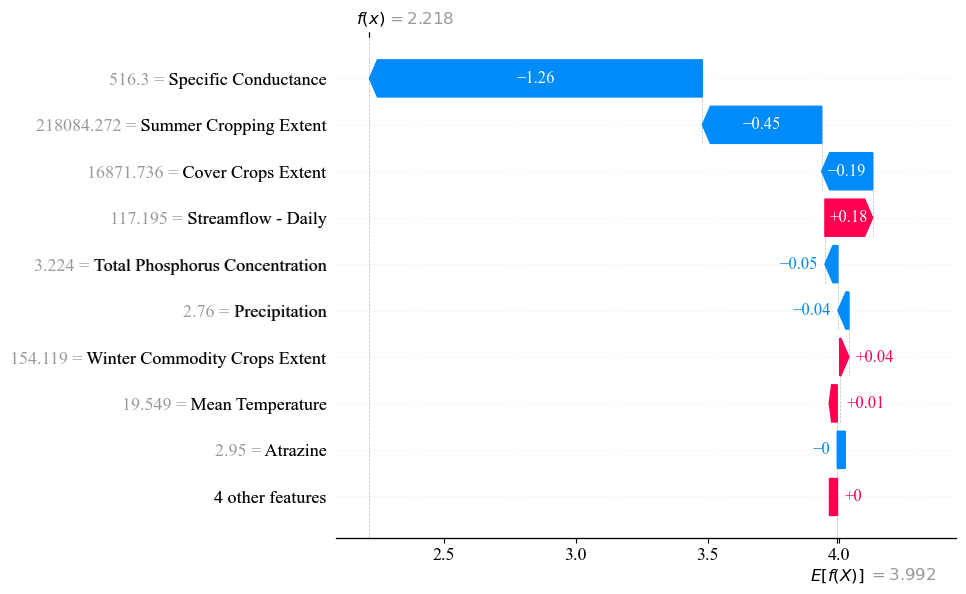

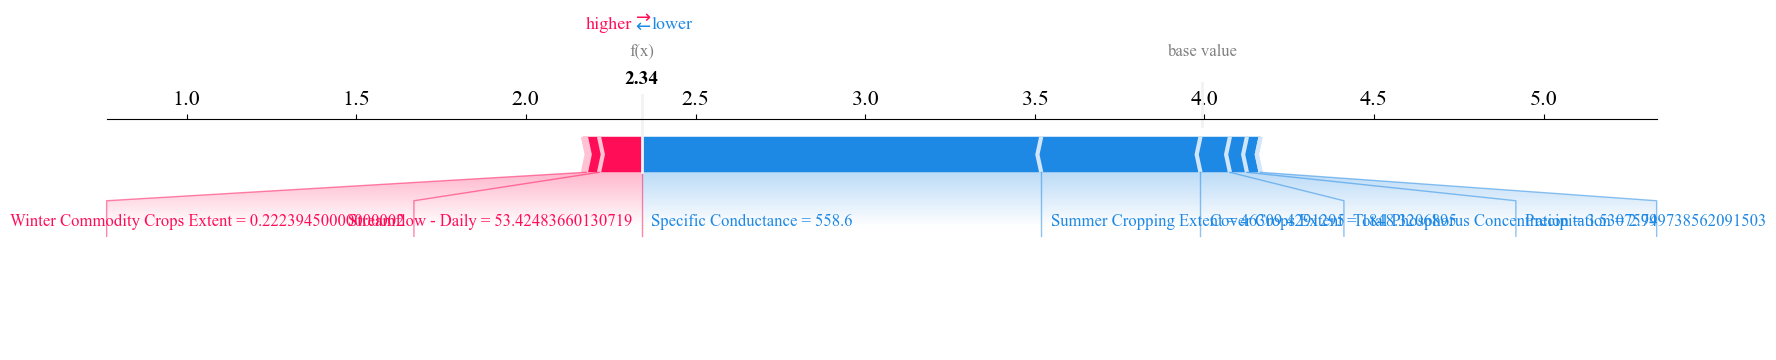

<Figure size 640x480 with 0 Axes>

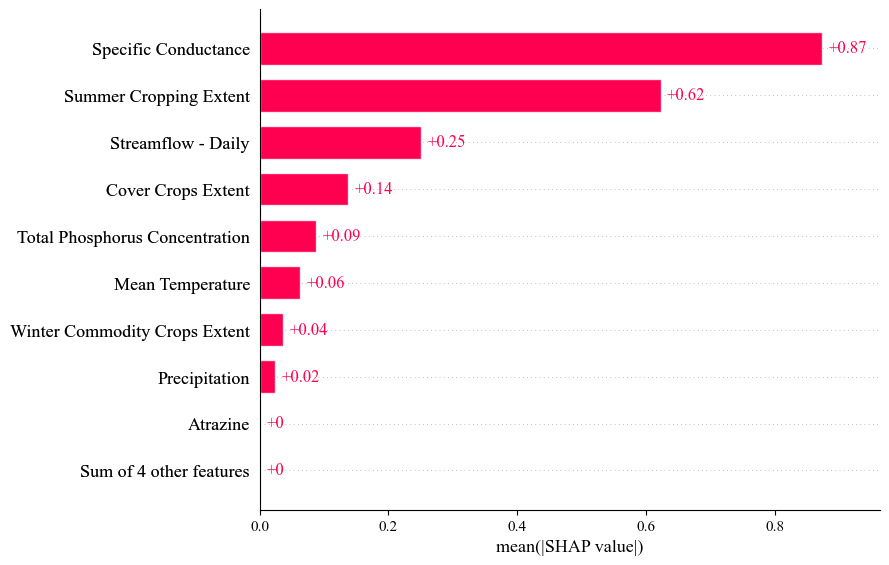

In [66]:
# Create waterfall plot for the third observation
plt.figure()
shap.plots.waterfall(shap_values[2])
# Create force plot for the third observation
shap.plots.force(shap_values[1], matplotlib=True)
# Create stacked force plot for the first 10 observations
plt.figure()
fp = shap.force_plot(shap_values[0:10])
shap.save_html('force_plot.html', fp)
# Create bar plot for all observations
plt.figure()
shap.plots.bar(shap_values)

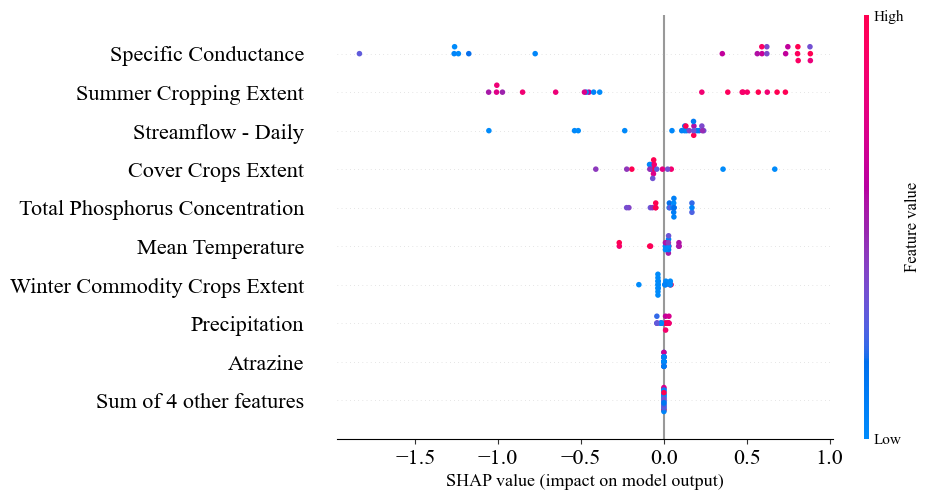

In [67]:
font_prop = fm.FontProperties(family="Times New Roman", size=16)
# Plot beeswarm
shap.plots.beeswarm(shap_values, show=False)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_prop)
    label.set_color("black")
ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.set_title(ax.get_title(), fontproperties=font_prop, color="black")
plt.show()

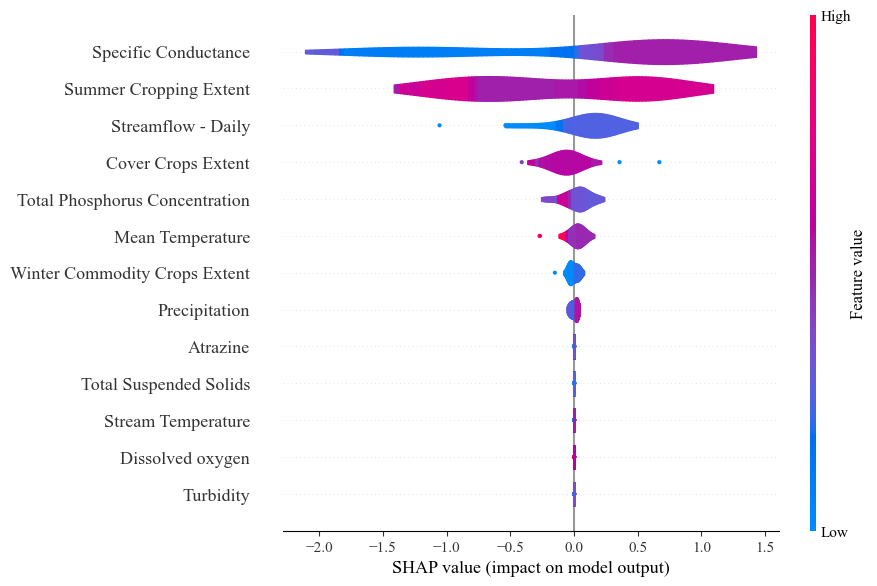

In [68]:
# Create violin plot for all observations
plt.figure()
shap.plots.violin(shap_values)

In [69]:
#Total phosphorus

In [70]:
#For Growing Season Analysis - May to September
Inorganic_Nitrate_data_G = pd.read_excel("NDEE Nitrate_Filtered.xlsx")
Inorganic_Nitrate_data_G['Date'] = pd.to_datetime(Inorganic_Nitrate_data_G['Date'])
Inorganic_Nitrate_data_filtered_G = Inorganic_Nitrate_data_G[Inorganic_Nitrate_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Inorganic_Nitrate_data_filtered_G['Year'] = Inorganic_Nitrate_data_filtered_G['Date'].dt.year
Inorganic_Nitrate_data_yearly_avg_G = Inorganic_Nitrate_data_filtered_G.groupby('Year')['Inorganic Nitrogen Concentration'].mean()

Total_Phosphorus_data_G = pd.read_excel("NDEE Total Phosphorus_Filtered.xlsx")
Total_Phosphorus_data_G['Date'] = pd.to_datetime(Total_Phosphorus_data_G['Date'])
Total_Phosphorus_data_filtered_G = Total_Phosphorus_data_G[Total_Phosphorus_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Phosphorus_data_filtered_G['Year'] = Total_Phosphorus_data_filtered_G['Date'].dt.year
Total_Phosphorus_data_yearly_avg_G = Total_Phosphorus_data_filtered_G.groupby('Year')['Total Phosphorus Concentration'].mean()

Turbidity_data_G = pd.read_excel("NDEE_Turbidity_Filtered.xlsx")
Turbidity_data_G['Date'] = pd.to_datetime(Turbidity_data_G['Date'])
Turbidity_data_filtered_G = Turbidity_data_G[Turbidity_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Turbidity_data_filtered_G['Year'] = Turbidity_data_filtered_G['Date'].dt.year
Turbidity_data_yearly_avg_G = Turbidity_data_filtered_G.groupby('Year')['Turbidity'].mean()

Total_Suspended_Solids_data_G = pd.read_excel("NDEE Total Suspended Solids_Filtered.xlsx")
Total_Suspended_Solids_data_G['Date'] = pd.to_datetime(Total_Suspended_Solids_data_G['Date'])
Total_Suspended_Solids_data_filtered_G = Total_Suspended_Solids_data_G[Total_Suspended_Solids_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Total_Suspended_Solids_data_filtered_G['Year'] = Total_Suspended_Solids_data_filtered_G['Date'].dt.year
Total_Suspended_Solids_data_yearly_avg_G = Total_Suspended_Solids_data_filtered_G.groupby('Year')['Total Suspended Solids'].mean()

Stream_Temperature_data_G = pd.read_excel("NDEE Stream Temperature_Filtered.xlsx")
Stream_Temperature_data_G['Date'] = pd.to_datetime(Stream_Temperature_data_G['Date'])
Stream_Temperature_data_filtered_G = Stream_Temperature_data_G[Stream_Temperature_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Stream_Temperature_data_filtered_G['Year'] = Stream_Temperature_data_filtered_G['Date'].dt.year
Stream_Temperature_data_yearly_avg_G = Stream_Temperature_data_filtered_G.groupby('Year')['Stream Temperature'].mean()

Specific_Conductance_data_G = pd.read_excel("NDEE Specific Conductance_Filtered.xlsx")
Specific_Conductance_data_G['Date'] = pd.to_datetime(Specific_Conductance_data_G['Date'])
Specific_Conductance_data_filtered_G = Specific_Conductance_data_G[Specific_Conductance_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Specific_Conductance_data_filtered_G['Year'] = Specific_Conductance_data_filtered_G['Date'].dt.year
Specific_Conductance_data_yearly_avg_G = Specific_Conductance_data_filtered_G.groupby('Year')['Specific Conductance'].mean()

Dissolved_Oxygen_data_G = pd.read_excel("NDEE Dissolved Oxygen_Filtered.xlsx")
Dissolved_Oxygen_data_G['Date'] = pd.to_datetime(Dissolved_Oxygen_data_G['Date'])
Dissolved_Oxygen_data_filtered_G = Dissolved_Oxygen_data_G[Dissolved_Oxygen_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Dissolved_Oxygen_data_filtered_G['Year'] = Dissolved_Oxygen_data_filtered_G['Date'].dt.year
Dissolved_Oxygen_data_yearly_avg_G = Dissolved_Oxygen_data_filtered_G.groupby('Year')['Dissolved oxygen'].mean()

Atrazine_data_G = pd.read_excel("NDEE Atrazine_Filtered.xlsx")
Atrazine_data_G['Date'] = pd.to_datetime(Atrazine_data_G['Date'])
Atrazine_data_filtered_G = Atrazine_data_G[Atrazine_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
Atrazine_data_filtered_G['Year'] = Atrazine_data_filtered_G['Date'].dt.year
Atrazine_data_yearly_avg_G = Atrazine_data_filtered_G.groupby('Year')['Atrazine'].mean()

EColi_data_G = pd.read_excel("NDEE E Coli_Filtered.xlsx")
EColi_data_G['Date'] = pd.to_datetime(EColi_data_G['Date'])
EColi_data_filtered_G = EColi_data_G[EColi_data_G['Date'].dt.month.isin([5, 6, 7, 8, 9])].copy()
EColi_data_filtered_G['Year'] = EColi_data_filtered_G['Date'].dt.year
EColi_data_yearly_avg_G = EColi_data_filtered_G.groupby('Year')['E. Coli'].mean()


WQ_Data_GrowingS = pd.concat([Inorganic_Nitrate_data_yearly_avg_G, Total_Phosphorus_data_yearly_avg_G, Turbidity_data_yearly_avg_G, 
                              Total_Suspended_Solids_data_yearly_avg_G,
                            Stream_Temperature_data_yearly_avg_G, Specific_Conductance_data_yearly_avg_G, Dissolved_Oxygen_data_yearly_avg_G,
                            Atrazine_data_yearly_avg_G, EColi_data_yearly_avg_G], axis = 1)

WQ_Data_GrowingS.reset_index(drop=True, inplace=True)
WQ_Data_GrowingS = WQ_Data_GrowingS.drop(columns=['E. Coli'])
WQ_Data_GrowingS

,Inorganic Nitrogen Concentration,Total Phosphorus Concentration,Turbidity,Total Suspended Solids,Stream Temperature,Specific Conductance,Dissolved oxygen,Atrazine
0,0.838673,0.323026,11.500000,14.000000,24.730000,581.000000,9.253333,0.966667
1,2.341049,3.530759,104.033333,2887.800000,20.092000,558.600000,6.760000,22.674000
2,2.217458,3.224359,1003.730000,1757.350000,21.430000,516.300000,9.954000,2.950000
3,2.011984,1.257671,44.796000,895.900000,21.987000,520.300000,9.240000,6.005556
4,1.914100,1.001750,108.883333,328.000000,21.440000,528.222222,8.521250,6.385000
5,5.153934,1.383316,362.566667,572.300000,22.655556,648.777778,6.754444,2.218889
6,3.610000,1.142500,516.720000,691.375000,20.952000,597.800000,8.100000,1.662000
7,3.570382,0.726215,285.872727,259.477273,19.712273,637.954545,8.769091,2.640909
8,3.622000,2.986800,1888.000000,2377.200000,21.094000,527.600000,6.334000,2.342000
9,3.910000,0.634600,165.360000,237.400000,20.992000,709.080000,8.724000,0.648000


In [71]:
Hydro_data = pd.read_csv("ShellCreek_Hydro_Data.csv")
Hydro_data['Date'] = pd.to_datetime(Hydro_data['Date'])
Hydro_data = Hydro_data[(Hydro_data['Date'] >= '2002-01-01') & (Hydro_data['Date'] <= '2021-12-31')]
Hydro_data.set_index('Date', inplace=True)
Hydro_data['Month'] = Hydro_data.index.month 
Hydro_data_filtered = Hydro_data[(Hydro_data['Month'] >= 5) & (Hydro_data['Month'] <= 9)]
Hydro_data_grouped = Hydro_data_filtered.groupby(Hydro_data_filtered.index.year).mean()
Hydro_data_grouped.reset_index(inplace=True)
Hydro_data_grouped.drop(columns=[ 'Date', 'Month', 'Snow Depth', 'Minimum Temperature', 'Maximum Temperature', 'Mean Temperature','Dew Point Temperature',
    'Maximum Vapor Pressure Deficit', 'Minimum Vapor Pressure Deficit','Precipitation'], inplace=True)
print(Hydro_data_grouped)

    Streamflow - Daily
0            30.467320
1            53.424837
2           117.195425
3            35.903007
4            20.842092
5            92.911765
6           214.258170
7            39.341830
8           185.623529
9            80.209804
10           31.388039
11           32.356863
12           48.076797
13           34.636601
14           88.869935
15           45.093922
16          104.845752
17           83.147712
18           43.253856
19           37.751895


In [72]:
Crop_Coverage = pd.read_excel("Shell Creek_Cover Crop Extent_1990-2021.xlsx")
Crop_Health = pd.read_excel("Shell Creek_Crop Persistence_1990-2021.xlsx")
Summer_Crop = pd.read_excel("Shell Creek_Summer Crop_1990-2021.xlsx")
CP_Data = pd.concat([Crop_Coverage, Crop_Health, Summer_Crop], axis = 1)
CP_Data = CP_Data.loc[:,~CP_Data.columns.duplicated()]
CP_Data = CP_Data[CP_Data['Year'] >= 2002]
CP_Data.reset_index(drop=True, inplace=True)
columns_to_retain = ['Vegetation Health', 'Cover Crops Extent', 'Winter Commodity Crops Extent','Summer Cropping Extent']
CP_Data = CP_Data[columns_to_retain]

In [73]:
All_Parameters = pd.concat([CP_Data, Hydro_data_grouped,  WQ_Data_GrowingS], axis = 1)
num_columns = All_Parameters.shape[1]
print("Number of columns:", num_columns)

Number of columns: 13


In [74]:
All_Parameters

,Vegetation Health,Cover Crops Extent,Winter Commodity Crops Extent,Summer Cropping Extent,Streamflow - Daily,Inorganic Nitrogen Concentration,Total Phosphorus Concentration,Turbidity,Total Suspended Solids,Stream Temperature,Specific Conductance,Dissolved oxygen,Atrazine
0,1365.502230,8223.481427,0.000000,294956.710277,30.467320,0.838673,0.323026,11.500000,14.000000,24.730000,581.000000,9.253333,0.966667
1,13760.659688,1848.320690,0.222395,46309.429130,53.424837,2.341049,3.530759,104.033333,2887.800000,20.092000,558.600000,6.760000,22.674000
2,1334.367000,16871.736348,154.119389,218084.272196,117.195425,2.217458,3.224359,1003.730000,1757.350000,21.430000,516.300000,9.954000,2.950000
3,2944.503180,8405.844917,1.111973,259956.486261,35.903007,2.011984,1.257671,44.796000,895.900000,21.987000,520.300000,9.240000,6.005556
4,4848.644889,6873.769206,0.444789,40247.177454,20.842092,1.914100,1.001750,108.883333,328.000000,21.440000,528.222222,8.521250,6.385000
5,43.589322,6710.309249,2.223945,305051.863815,92.911765,5.153934,1.383316,362.566667,572.300000,22.655556,648.777778,6.754444,2.218889
6,347.157815,8254.171868,0.000000,289777.364766,214.258170,3.610000,1.142500,516.720000,691.375000,20.952000,597.800000,8.100000,1.662000
7,15.345221,8624.236316,10.674936,203682.671559,39.341830,3.570382,0.726215,285.872727,259.477273,19.712273,637.954545,8.769091,2.640909
8,380.961779,1259.197659,568.662737,64632.734379,185.623529,3.622000,2.986800,1888.000000,2377.200000,21.094000,527.600000,6.334000,2.342000
9,507.726644,13515.136159,0.889578,195086.234556,80.209804,3.910000,0.634600,165.360000,237.400000,20.992000,709.080000,8.724000,0.648000


In [75]:
X = All_Parameters.drop('Total Phosphorus Concentration', axis=1)
y = All_Parameters['Total Phosphorus Concentration']

In [76]:
features = X.columns
features

Index(['Vegetation Health', 'Cover Crops Extent',
       'Winter Commodity Crops Extent', 'Summer Cropping Extent',
       'Streamflow - Daily', 'Inorganic Nitrogen Concentration', 'Turbidity',
       'Total Suspended Solids', 'Stream Temperature', 'Specific Conductance',
       'Dissolved oxygen', 'Atrazine'],
      dtype='object')

In [77]:
# Carry out train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# Configure and fit XGBoost
xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [78]:
# Predict using trained model 
y_pred = xgb.predict(X_test)
# Convert to numpy array
y_test = y_test.to_numpy().flatten()
KGE = calculate_KGE(y_pred, y_test)
print(f'KGE = {np.round(KGE, 2)}')

KGE = 0.6


The shape of shap_values is (20, 12)


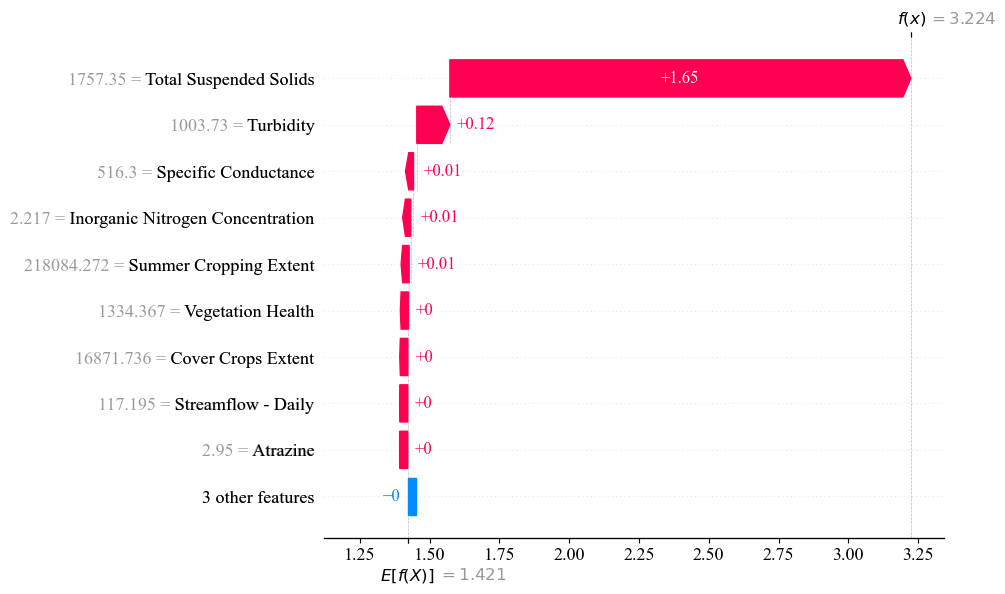

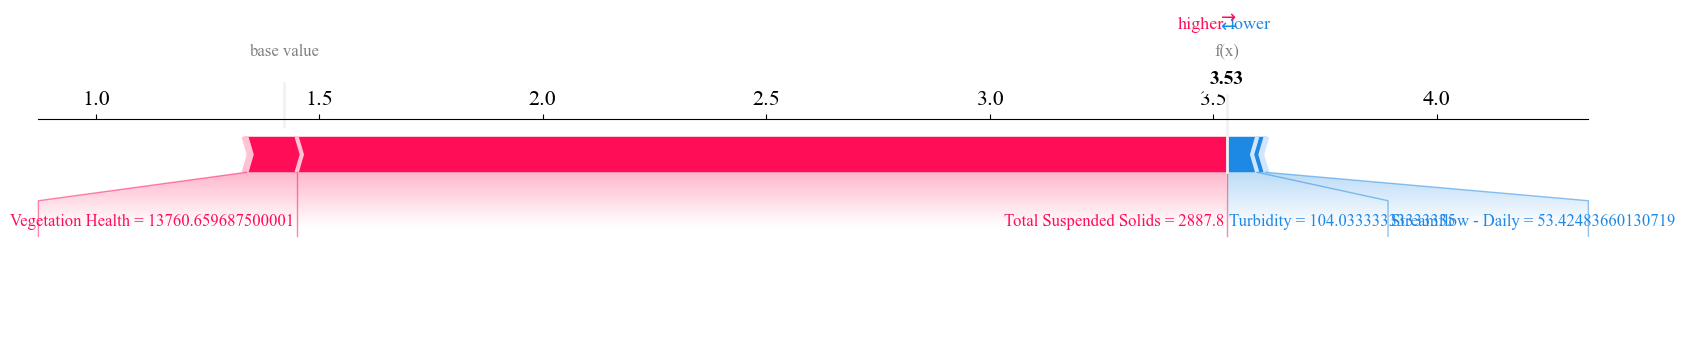

<Figure size 640x480 with 0 Axes>

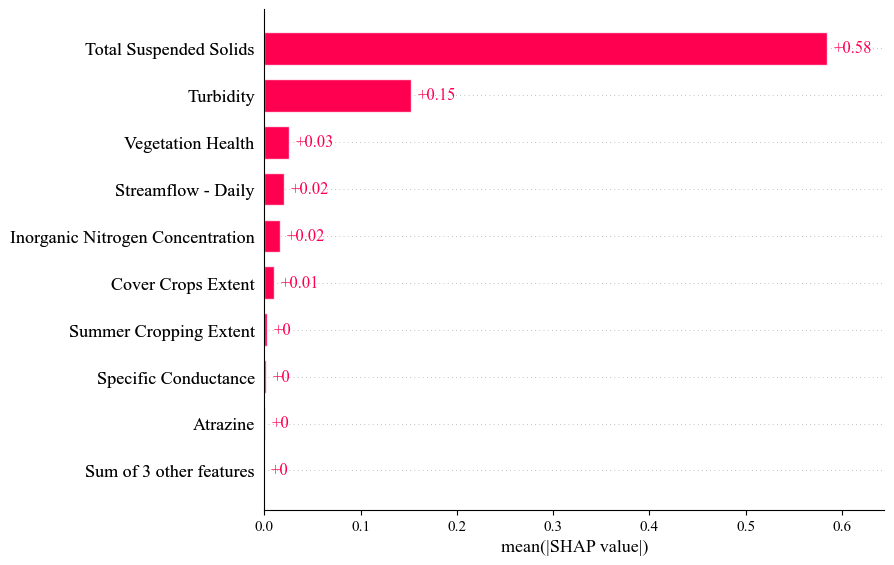

In [79]:
# Calculate SHAP values
shap_explainer = shap.Explainer(xgb)
shap_values = shap_explainer(X)
print(f'The shape of shap_values is {np.shape(shap_values.values)}')
# Create waterfall plot for the third observation
plt.figure()
shap.plots.waterfall(shap_values[2])
# Create force plot for the third observation
shap.plots.force(shap_values[1], matplotlib=True)
# Create stacked force plot for the first 10 observations
plt.figure()
fp = shap.force_plot(shap_values[0:10])
shap.save_html('force_plot.html', fp)
# Create bar plot for all observations
plt.figure()
shap.plots.bar(shap_values)

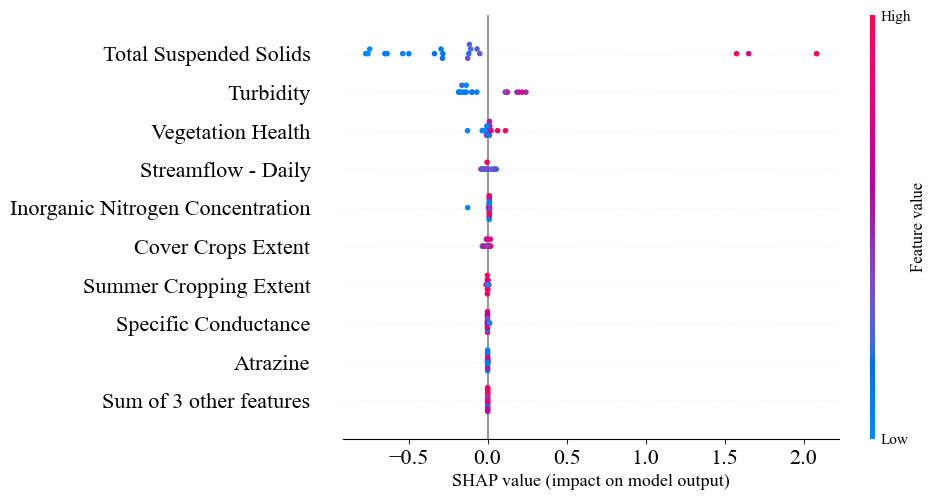

In [80]:
font_prop = fm.FontProperties(family="Times New Roman", size=16)
shap.plots.beeswarm(shap_values, show=False)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_prop)
    label.set_color("black")
ax.xaxis.label.set_color("black")
ax.yaxis.label.set_color("black")
ax.set_title(ax.get_title(), fontproperties=font_prop, color="black")
plt.show()

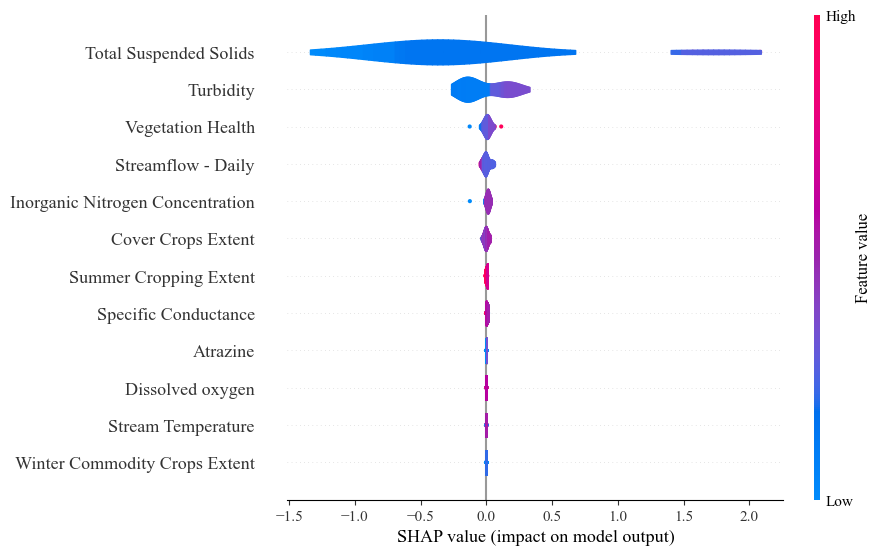

In [81]:
# Create violin plot for all observations
plt.figure()
shap.plots.violin(shap_values)